# 0.0. Import 

In [1]:
import math
import pandas as pd
import inflection 
import numpy as np
import seaborn as sns
import xgboost as xgb
import random
import pickle

from scipy import stats
#from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

#from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1 Helper Func


In [54]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n =cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    
    return np.sqrt((chi2/n) / (min (k-1, r-1)))


def m1_error(model_name, y, yhat):
    mae =  mean_absolute_error(y, yhat)
    mape = (mean_absolute_percentage_error(y,yhat))
    rsme = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RSME': rsme}, index=[0])



def cross_validation(x_training, kfold, model_name, model, verbose= False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range (1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #Start and End Date for Validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date)& (x_training['date'] <= validation_end_date)]

        #training and validation dataset

        #training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']


        #validation
        xvalidation=validation.drop(['date','sales'], axis=1)
        yvalidation=validation['sales']

        #model
        m = model.fit( xtraining, ytraining)

        #prodection
        yhat= m.predict(xvalidation)

        #performace and store of each kfold iteration
        m_result = m1_error( model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RSME'])

    return pd.DataFrame({'Model Name': model_name,
        'MAE CV': np.round( np.mean(mae_list),2).astype(str)+ ' +/- ' + np.round( np.std(mae_list),2).astype(str),
        'MAPE CV': np.round( np.mean(mape_list),2).astype(str)+ ' +/- ' + np.round( np.std(mape_list),2).astype(str),
        'RSME CV': np.round( np.mean(rmse_list),2).astype(str)+ ' +/- ' + np.round( np.std(rmse_list),2).astype(str)}, index=[0])



In [55]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/jefersonlima/.pyenv/versions/3.10.3/envs/RossmannStoreProject/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading data


In [4]:
df_sales_raw = pd.read_csv ('../rossmann-store-sales/train.csv', low_memory=False)
df_store_raw = pd.read_csv ('../rossmann-store-sales/store.csv', low_memory=False)

#merge
df_raw = pd.merge( df_sales_raw,df_store_raw, how='left', on='Store')

# 1.0 Descriçao de Dados

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#Rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of Columns: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Type

In [8]:
#Mudando DateTime
df1['date'] = pd.to_datetime(df1['date'])

#DataTypes
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
#checking Na
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill out NA

In [10]:
df1['competition_distance'].max()

df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
530251,297,4,2014-03-13,5095,623,1,0,0,0,a,a,2300.0,9.0,2010.0,0,NaN,NaN,NaN


In [11]:
#competition_distance    
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)
                                                              
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year   
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week 
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year  
df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval 
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [12]:
#checking NA
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Dtypes

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statiscal

In [14]:
num_attribute = df1.select_dtypes (include=['int64', 'float64'])
cat_attribute = df1.select_dtypes (exclude=['int64', 'float64','datetime64[ns]'])

### 1.7.1 Numerical Statiscal

In [15]:
#Central Tendency - mean, median 
ct1 = pd.DataFrame(num_attribute.apply(np.mean)).T
ct2 = pd.DataFrame(num_attribute.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attribute.apply(np.std)).T
d2 = pd.DataFrame(num_attribute.apply(min)).T
d3 = pd.DataFrame(num_attribute.apply(max)).T
d4 = pd.DataFrame(num_attribute.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attribute.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attribute.apply(lambda x: x.kurtosis())).T
                  
#concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes' ,'min' ,'max' ,'range' ,'mean' ,'median' ,'std' ,'skew' ,'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/var/folders/55/kp2841xx6lgfq642dzt475640000gn/T/ipykernel_10009/3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<AxesSubplot: xlabel='competition_distance', ylabel='Density'>

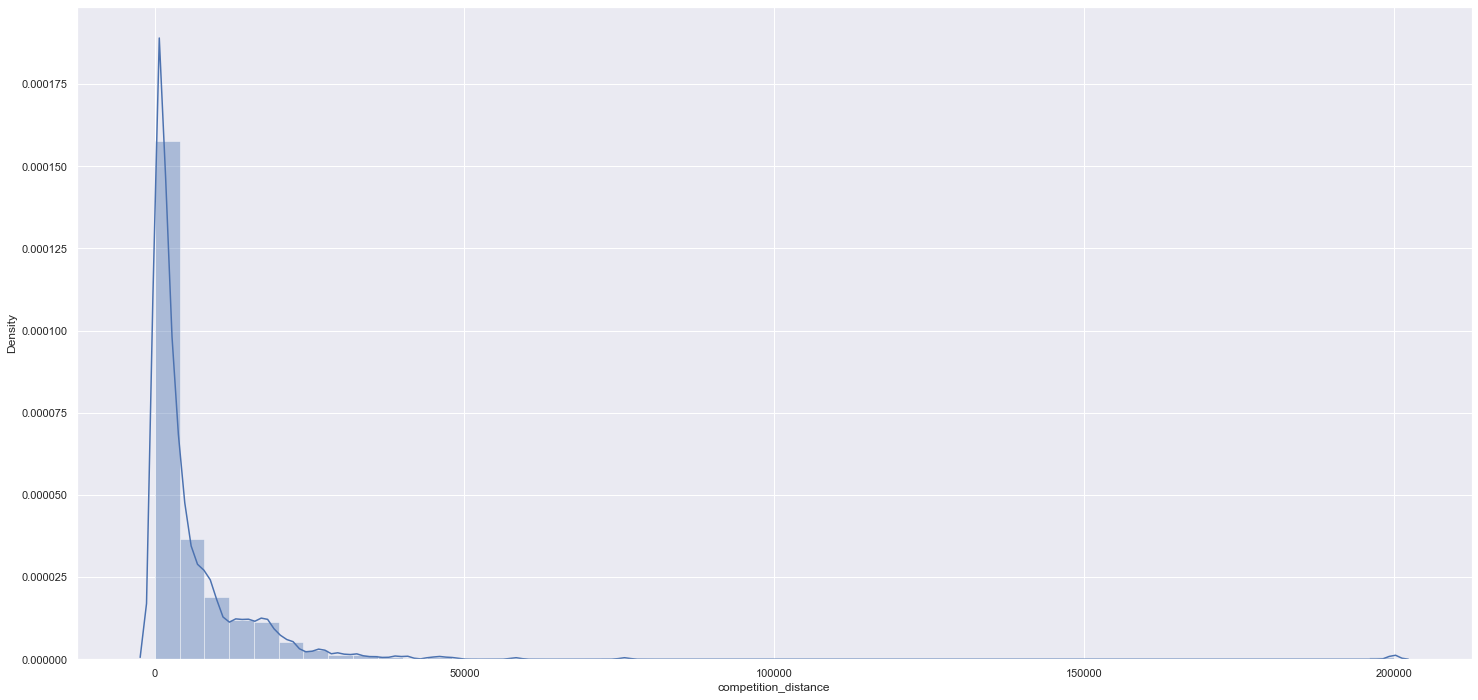

In [18]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Statiscal

In [24]:
cat_attribute.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

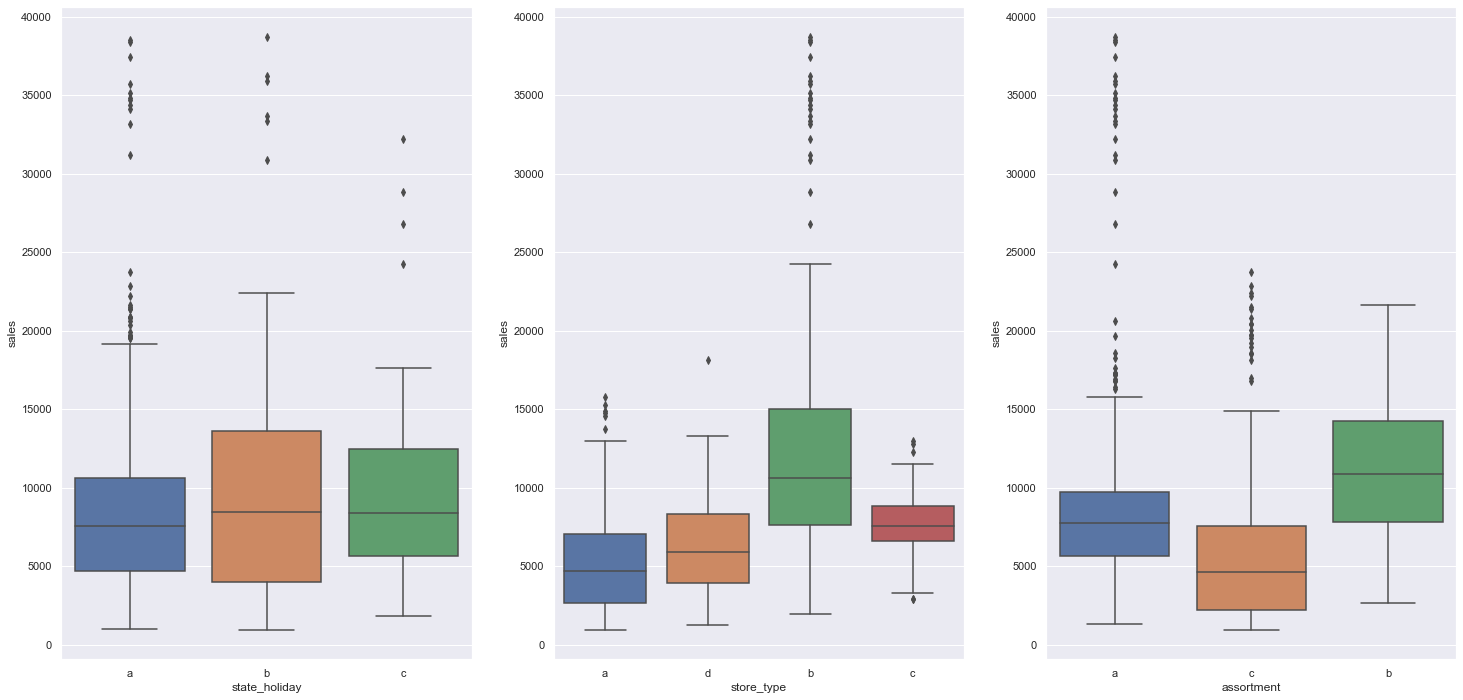

In [25]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales' ,  data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales' ,  data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales' ,  data=aux1)

# 2.0 Criacao de Hipoteses

In [26]:
df2 = df1.copy()

In [27]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


## 2.1.1 Hipoteses Loja

**1.** Lojas com Maior Quadro de Funcionarios, deveriam vender mais.

**2.** Lojas com Maior Estoque, deveriam Vender mais.

**3** Lojas com Maior Porte, deveriam vender mais.

**4** Lojas com menor Porte, deveriam vender menos.

**5** Lojas com maior sortimento, deveriam vender mais.

## 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing, deveriam vender mais.

**2.** Lojas que Expoem mais o Produto nas Vitrine, deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos, deveriam vender mais.

**4.** Lojas que tem precos menores em mais tempo, deveriam vender mais.

## 2.1.3 Hipoteses Tempo

**1.** Lojas que tem mais possuem mais Feriado, deveriam vender menos.

**2.** Lojas que abrem no primeiro 6m, deveriam vender mais

**3.** Lojas que abrem nos finais de semana, deveriam vender mais.

## 2.3. Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

--//--

**14.** Lojas com mais Funcionarios, devem vender mais

**15.** Lojas com Maior Porte, deveriam vender mais.


## 2.4. Feature Engineering

In [28]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], 
                                                                  month=x['competition_open_since_month'],day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' 
                                                  else 'christmas' if x == 'c' else 'regular_day' )


# 3.0. Filtragem de Variaveis

In [29]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [32]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0  Analise Exploratoria do Dados

In [33]:
df4 = df3.copy()

## 4.1 - Analise Univariada

### 4.1.1 - Response Variable

/var/folders/55/kp2841xx6lgfq642dzt475640000gn/T/ipykernel_10009/1473926699.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'])


<AxesSubplot: xlabel='sales', ylabel='Density'>

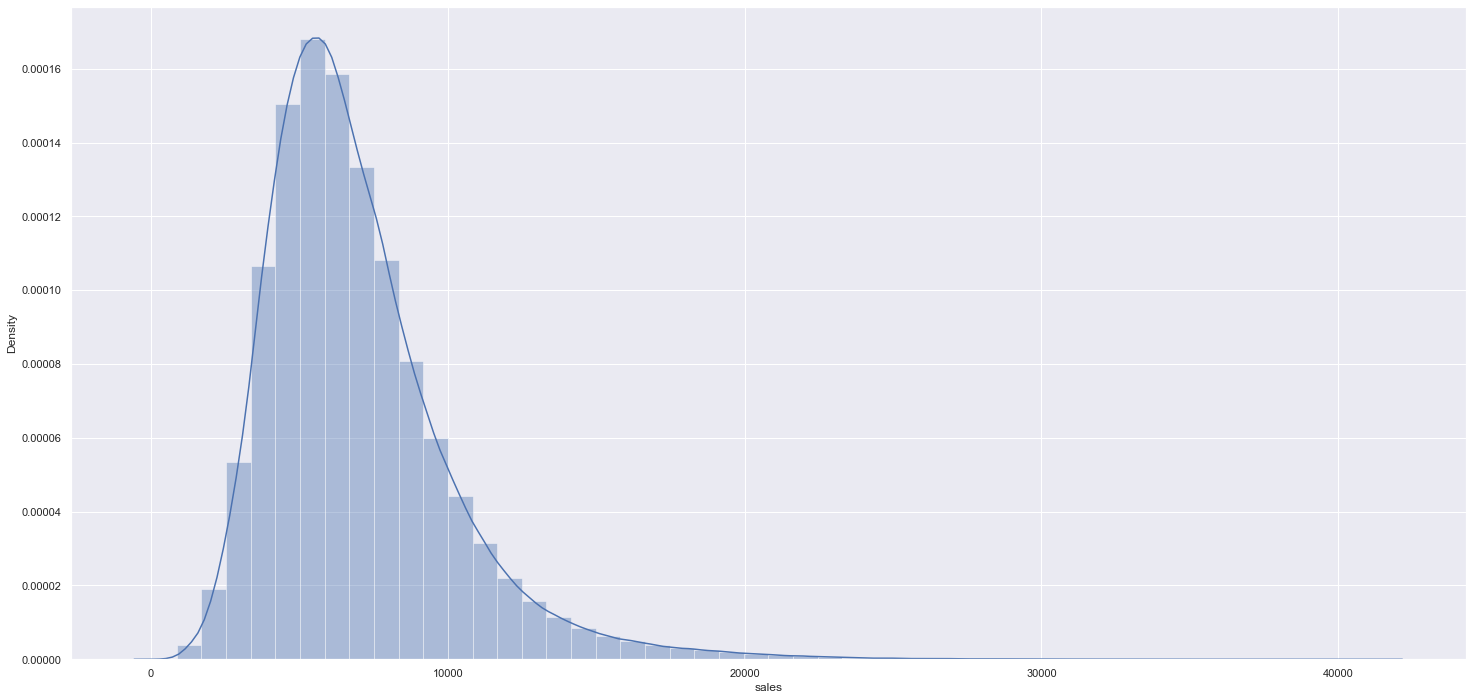

In [34]:
sns.distplot(df4['sales'])

### 4.1.2 - Numerical Variable

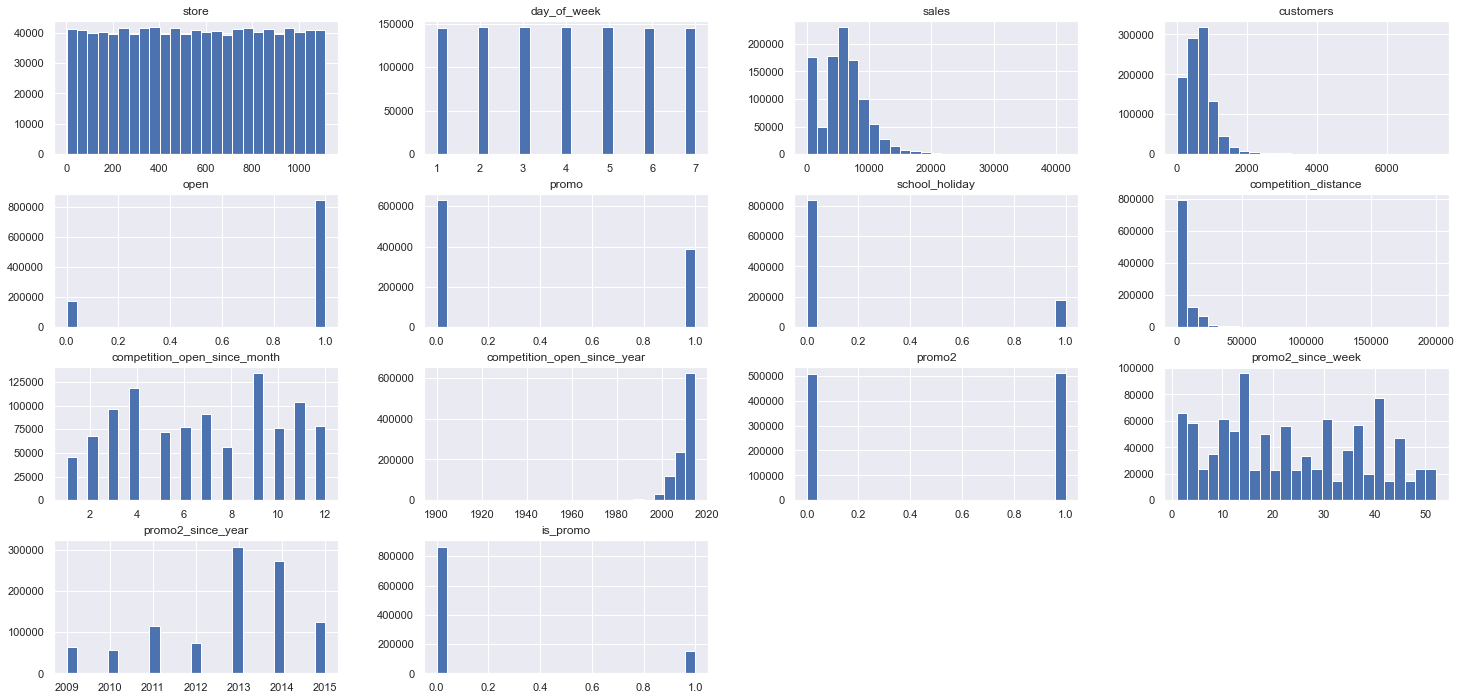

In [35]:
num_attribute.hist(bins=25);

### 4.1.3 - Categorical Variable

In [36]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

KeyError: 0

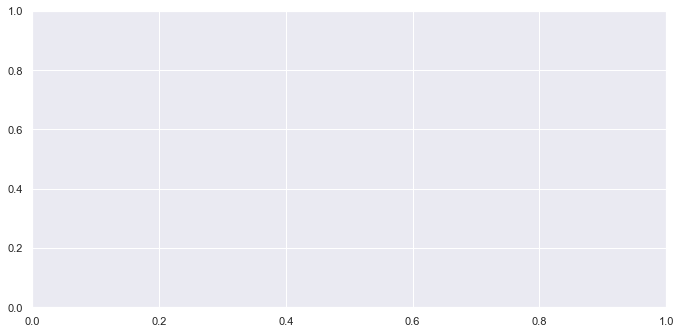

In [37]:
#state_holiday
plt.subplot(2,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(2,2,2)
sns.kdeplot (df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot (df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot (df4[df4['state_holiday'] == 'christmas']['sales'],  label='christmas', shade=True)

#store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot (df4[df4['store_type'] == 'a']['sales'],  label='a', shade=True)
sns.kdeplot (df4[df4['store_type'] == 'b']['sales'],  label='b', shade=True)
sns.kdeplot (df4[df4['store_type'] == 'c']['sales'],  label='c', shade=True)
sns.kdeplot (df4[df4['store_type'] == 'd']['sales'],  label='d', shade=True)

#assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot (df4[df4['assortment'] == 'basic']['sales'],  label='basic', shade=True)
sns.kdeplot (df4[df4['assortment'] == 'extended']['sales'],  label='extended', shade=True)
sns.kdeplot (df4[df4['assortment'] == 'extra']['sales'],  label='extra', shade=True)

## 4.2 - Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

False: Lojas com maior sortimentos vendem menos

<AxesSubplot: xlabel='year_week'>

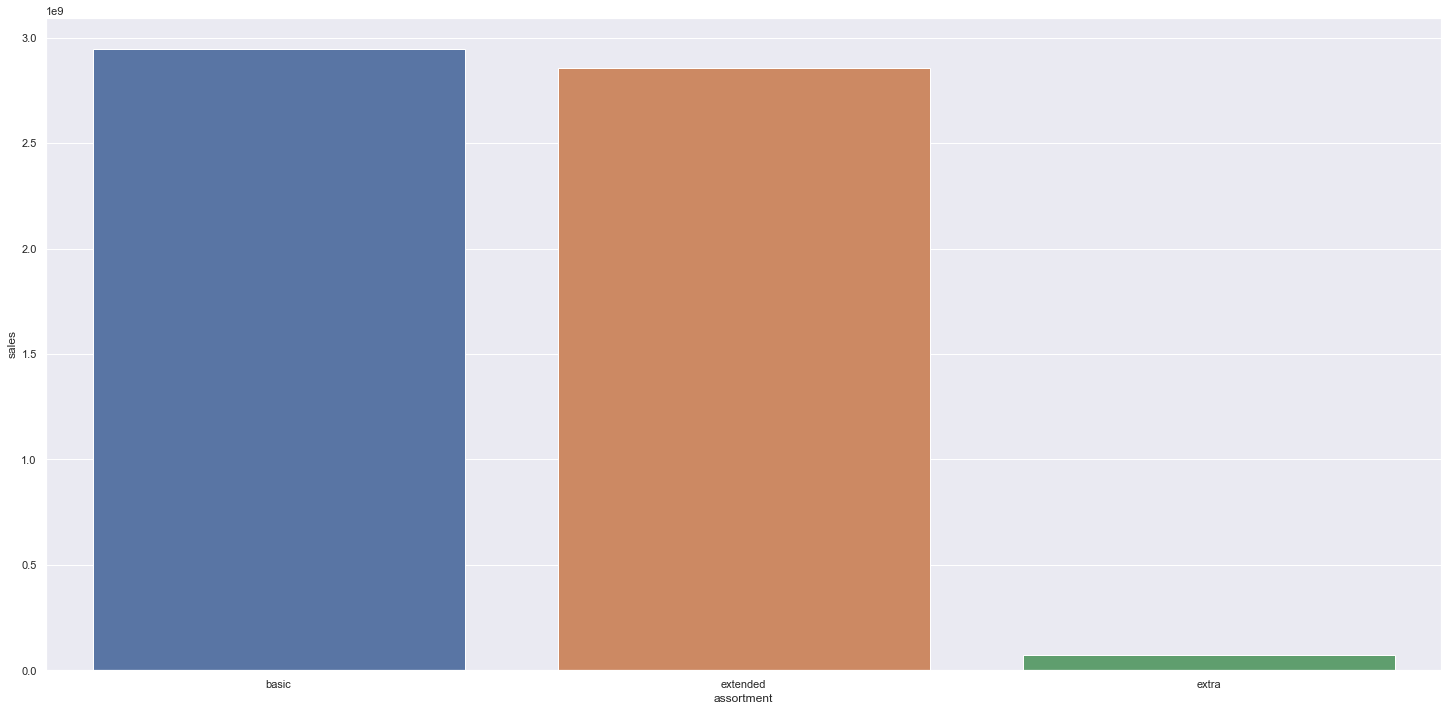

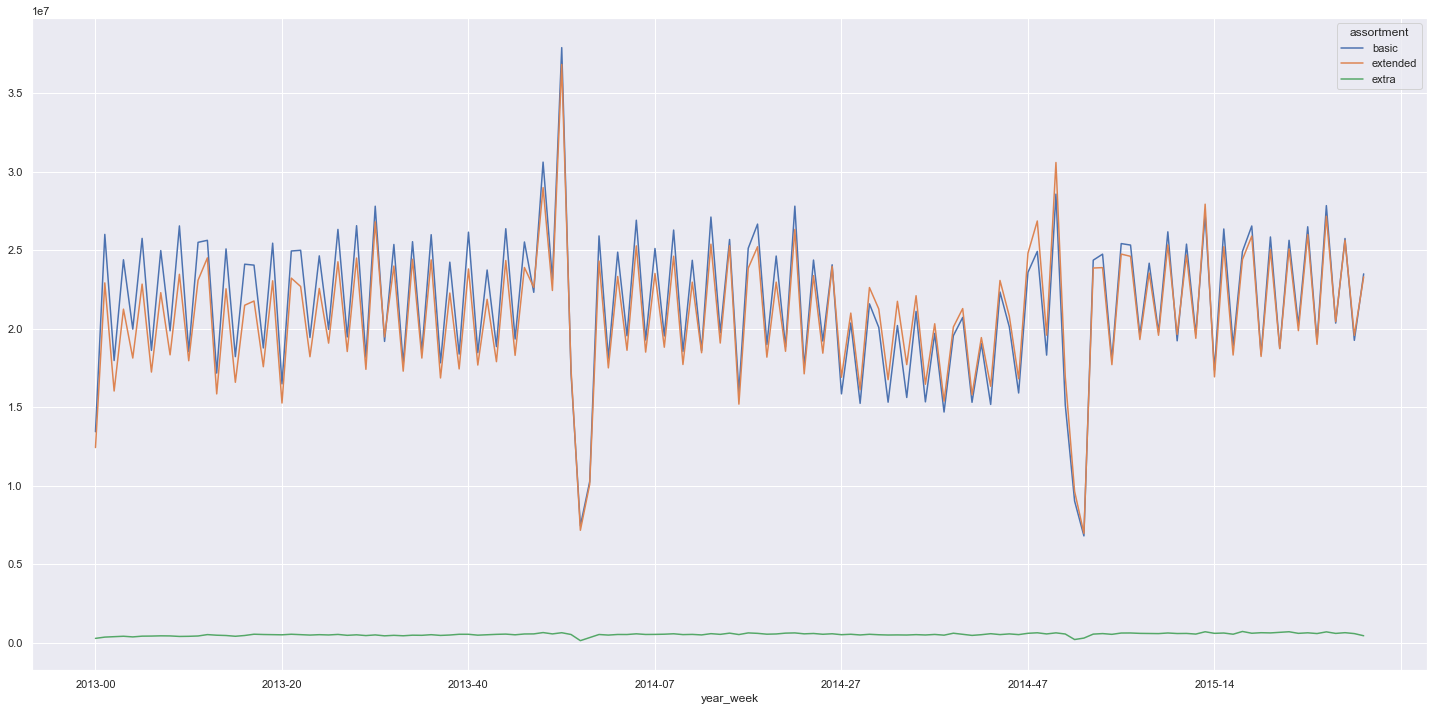

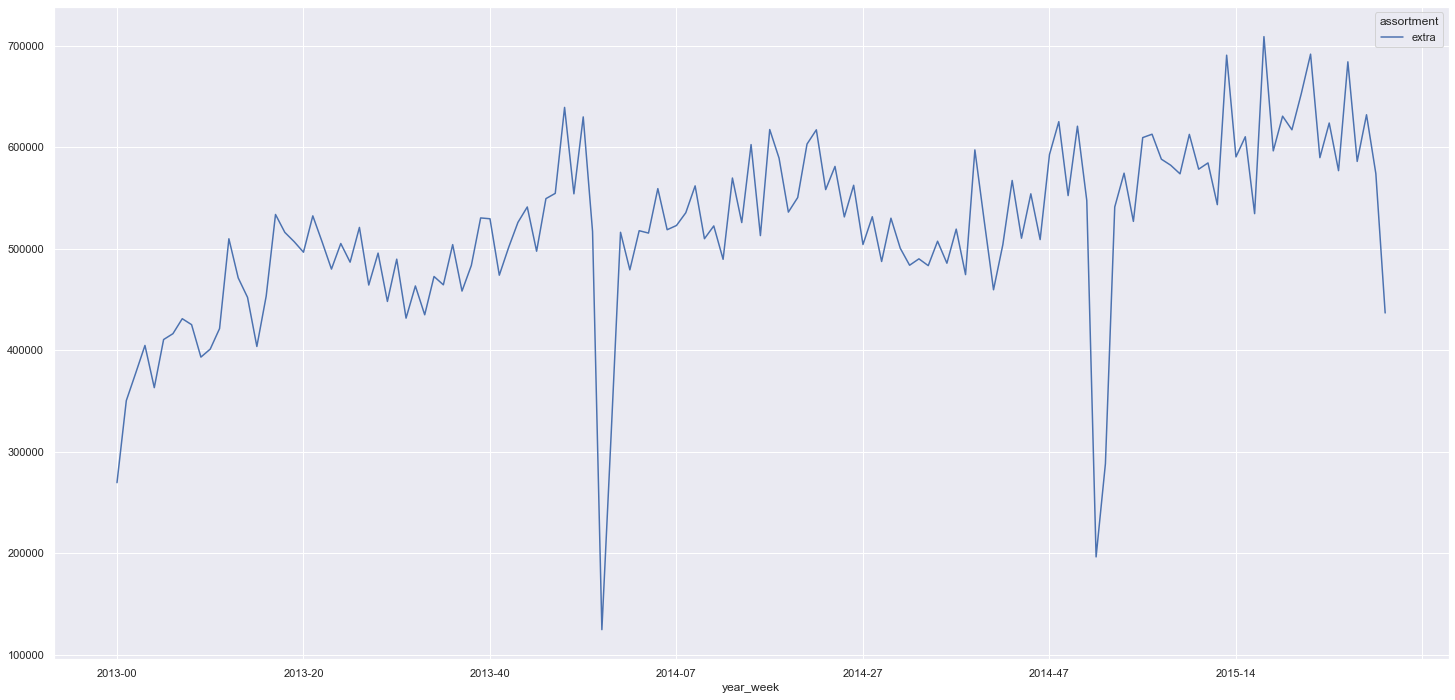

In [38]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment' , y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week'  , columns='assortment' , values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week'  , columns='assortment' , values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

False- Lojas com COMPETIDORES MAIS PROXIMOS, vendem MAIS

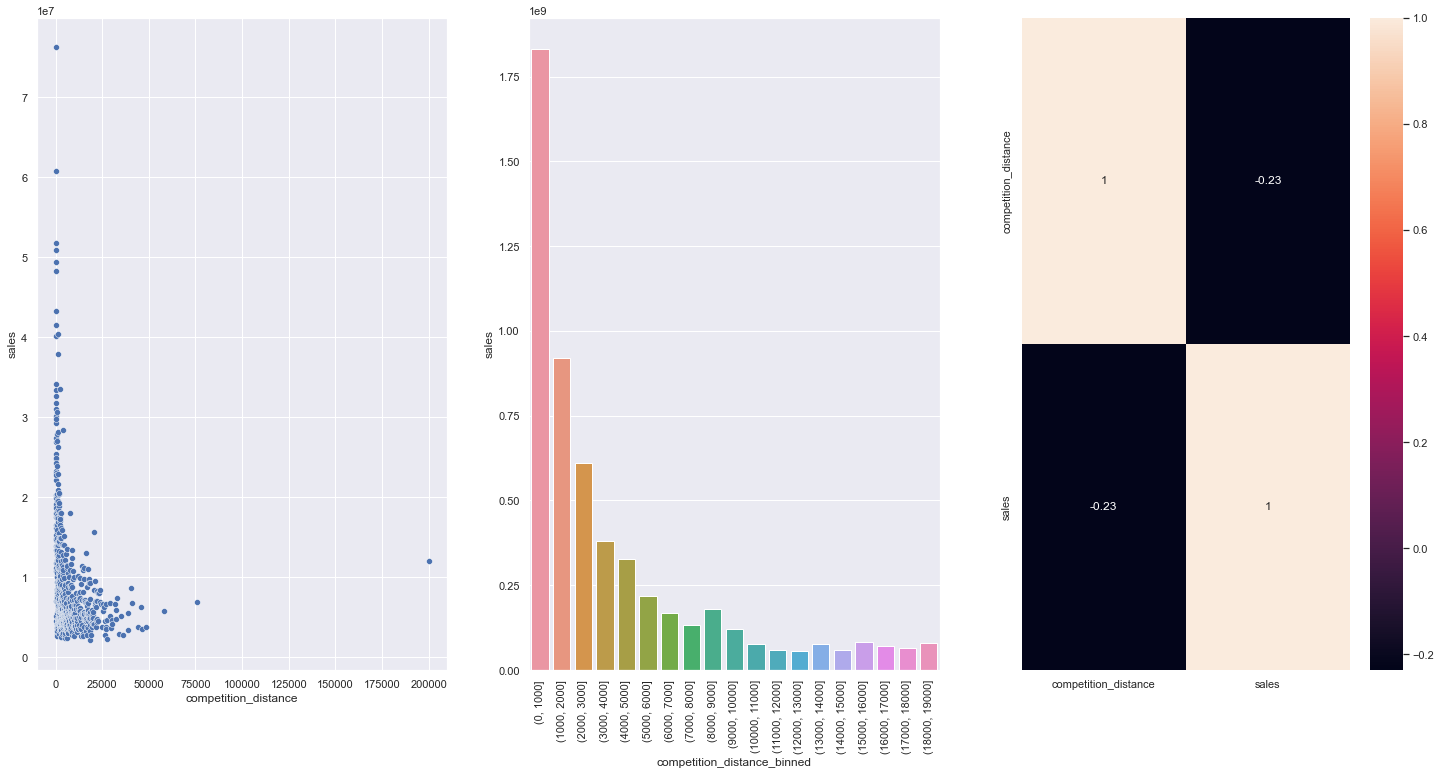

In [39]:
aux1= df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2= aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned' , y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H3 Lojas com competidores à mais tempo deveriam vendem mais.

False:  Lojas com Competidores a MAIS TEMPOS, VENDEM a MENOS

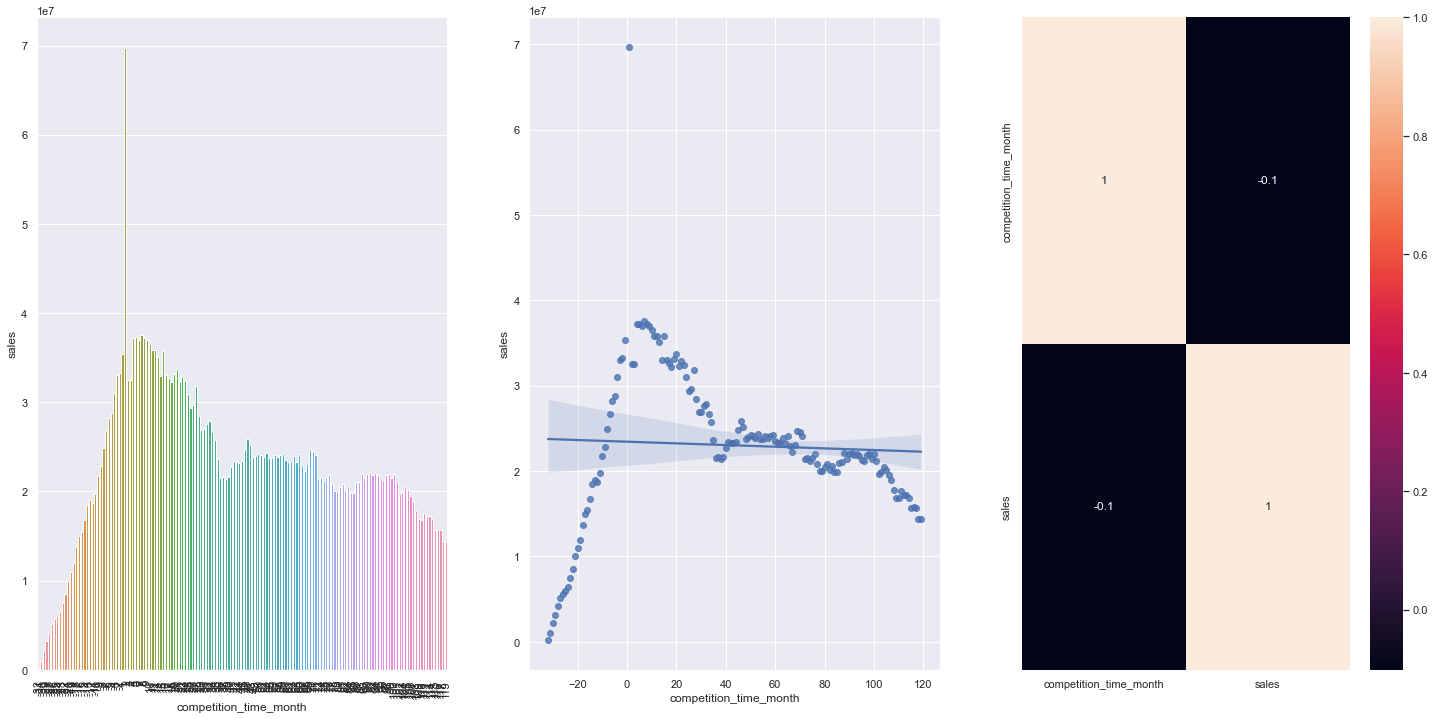

In [40]:
plt.subplot(1,3,1)
aux1= df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot (x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot (x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

Falsa, lojas com promocoes ativas VENDEM MENOS, depois de um PERIODO DE PROMOCAO

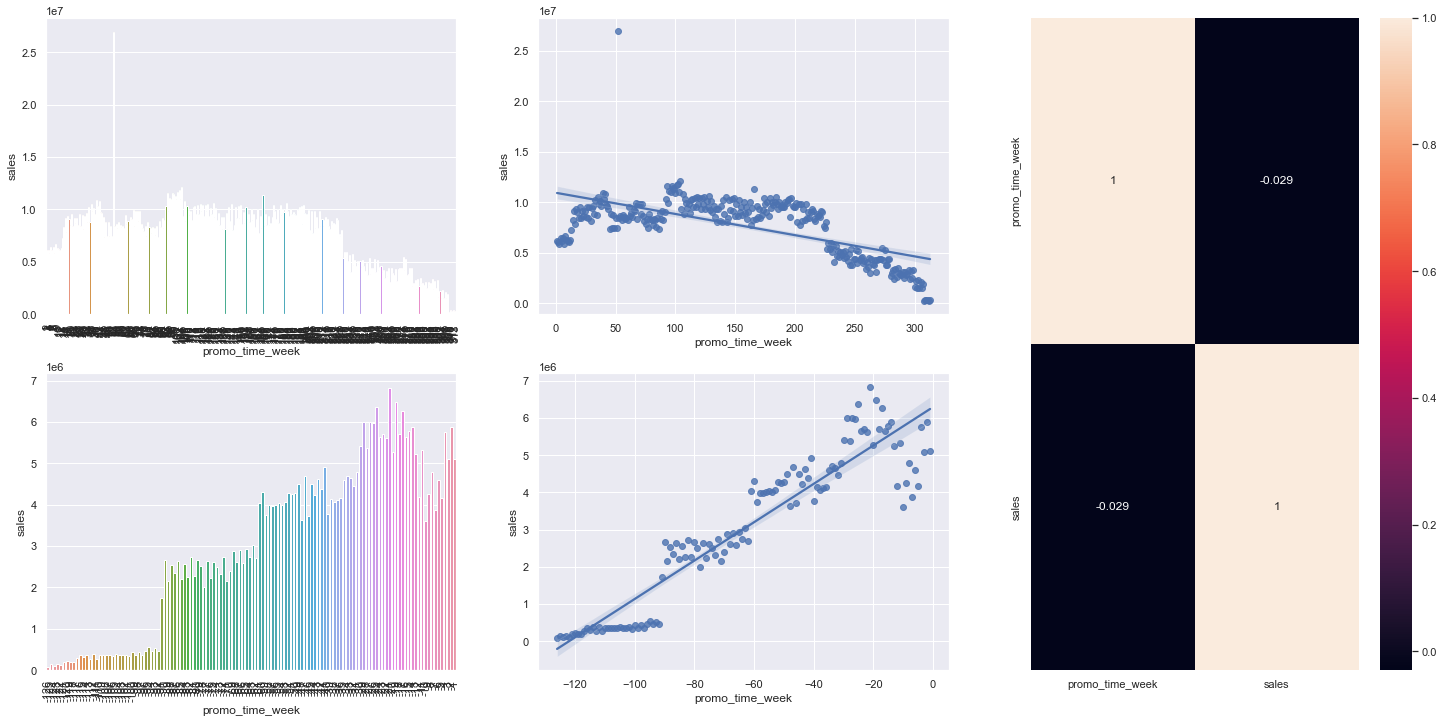

In [41]:
aux1= df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()


grid = GridSpec(2,3)

plt.subplot(grid[0,0]) 
aux2 = aux1[aux1['promo_time_week']> 0] #promo extendido
sns.barplot(x='promo_time_week',y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']< 0] #promo regular
sns.barplot(x='promo_time_week',y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr( method='pearson'), annot=True);



### H5. Lojas com mais dias de promoção deveriam vender mais.

In [42]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### H6. Lojas com mais promoções consecutivas deveriam vender mais.

Falsa, lojas com MAIS PROMOCOES EXTENDIDAS, VENDEM MENOS

In [43]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.

Falsa, não vende mais.

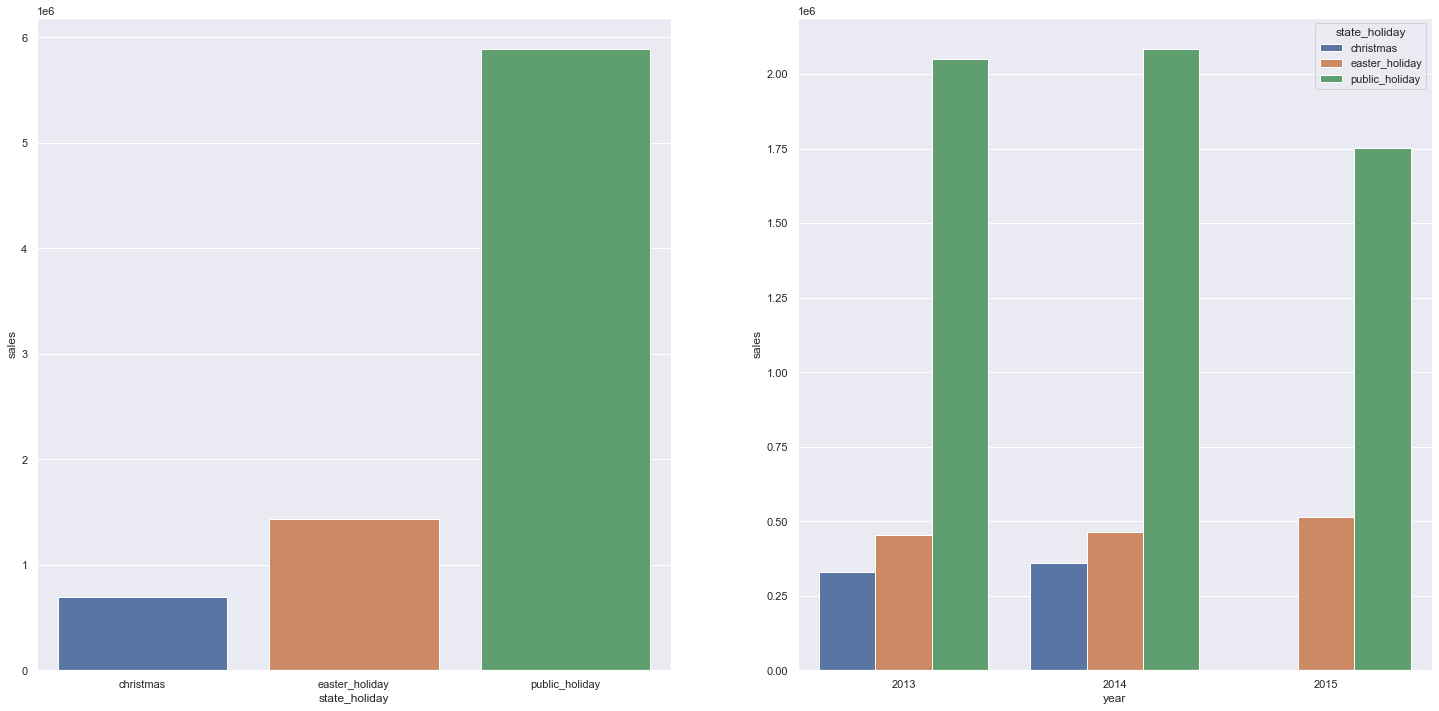

In [44]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday']!= 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);


### H9. Lojas deveriam vender mais ao longo dos anos.

Falsa, Lojas vendem menos

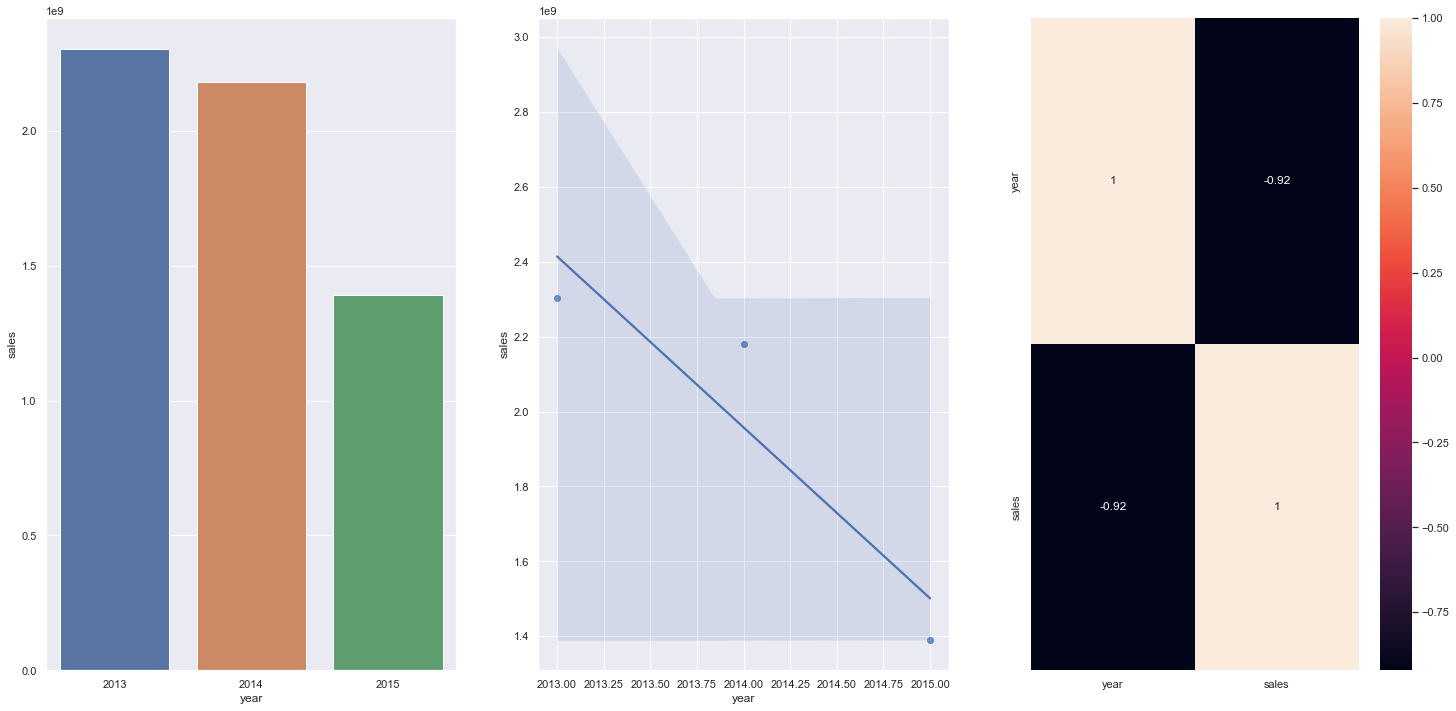

In [45]:
aux3 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux3);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux3);

plt.subplot(1,3,3)
sns.heatmap(aux3.corr(method ='pearson'), annot=True);


### H10. Lojas deveriam vender mais no segundo semestre do ano.

FALSA, As lojas vendem menos no 2. Semestre

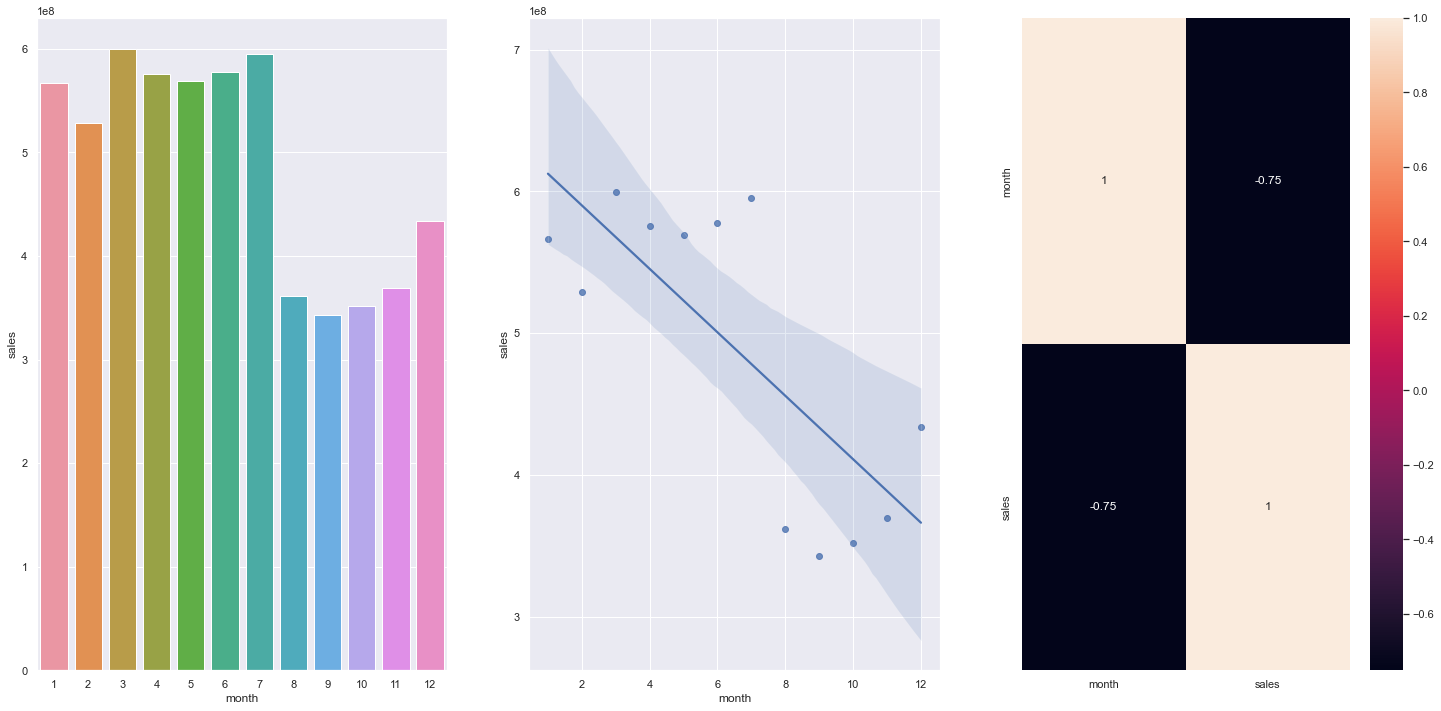

In [46]:
aux3 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux3);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux3);

plt.subplot(1,3,3)
sns.heatmap(aux3.corr(method ='pearson'), annot=True);


###  11. Lojas deveriam vender mais depois do dia 10 de cada mês.
 Verdadeira, porque as lojas VENDEM mais depois do dia 10

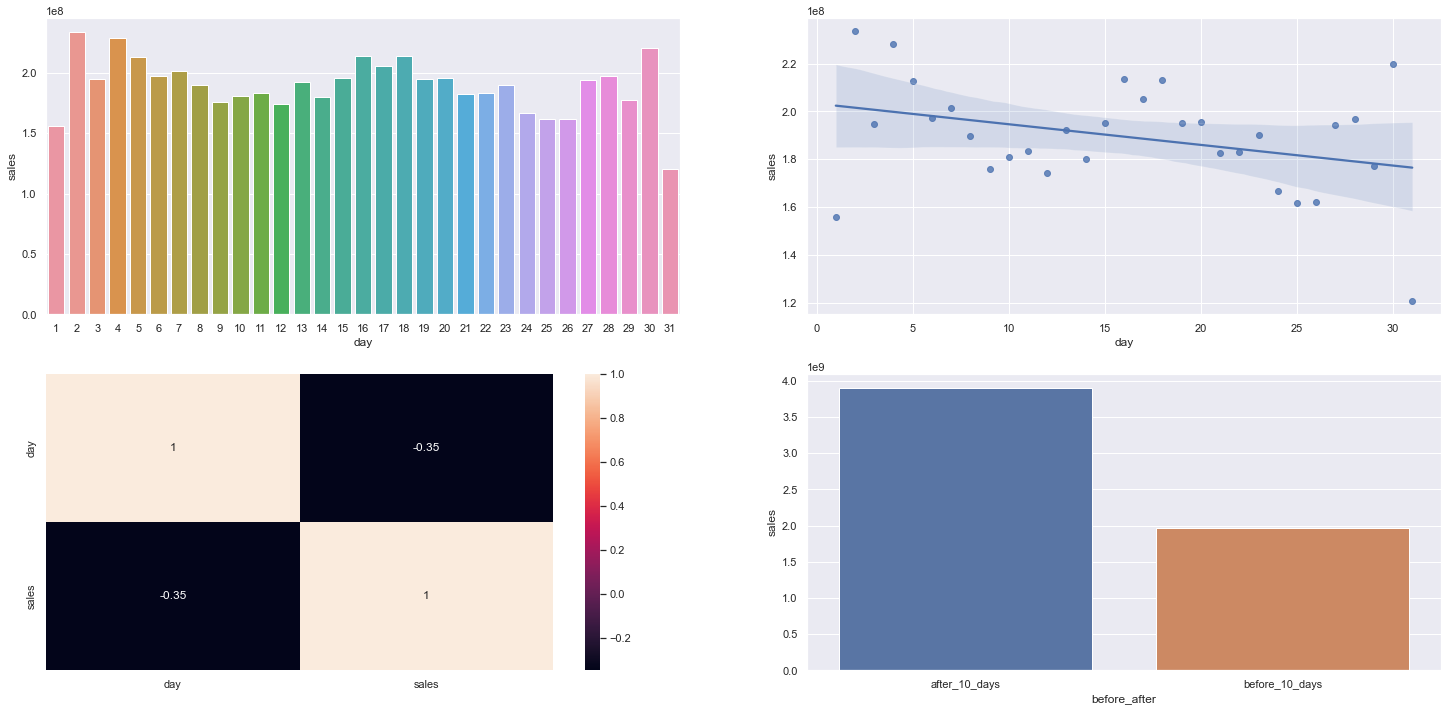

In [47]:
aux3 = df4[['day','sales']].groupby('day').sum().reset_index()

aux3['before_after'] = aux3['day'].apply (lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux4 = aux3[['before_after','sales']].groupby('before_after').sum().reset_index() 

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux3);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux3);

plt.subplot(2,2,3)
sns.heatmap(aux3.corr(method ='pearson'), annot=True);

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux4);

### 12. Lojas deveriam vender menos aos finais de semana.

Verdadeira, loja vendem menos aos Finais de Semana

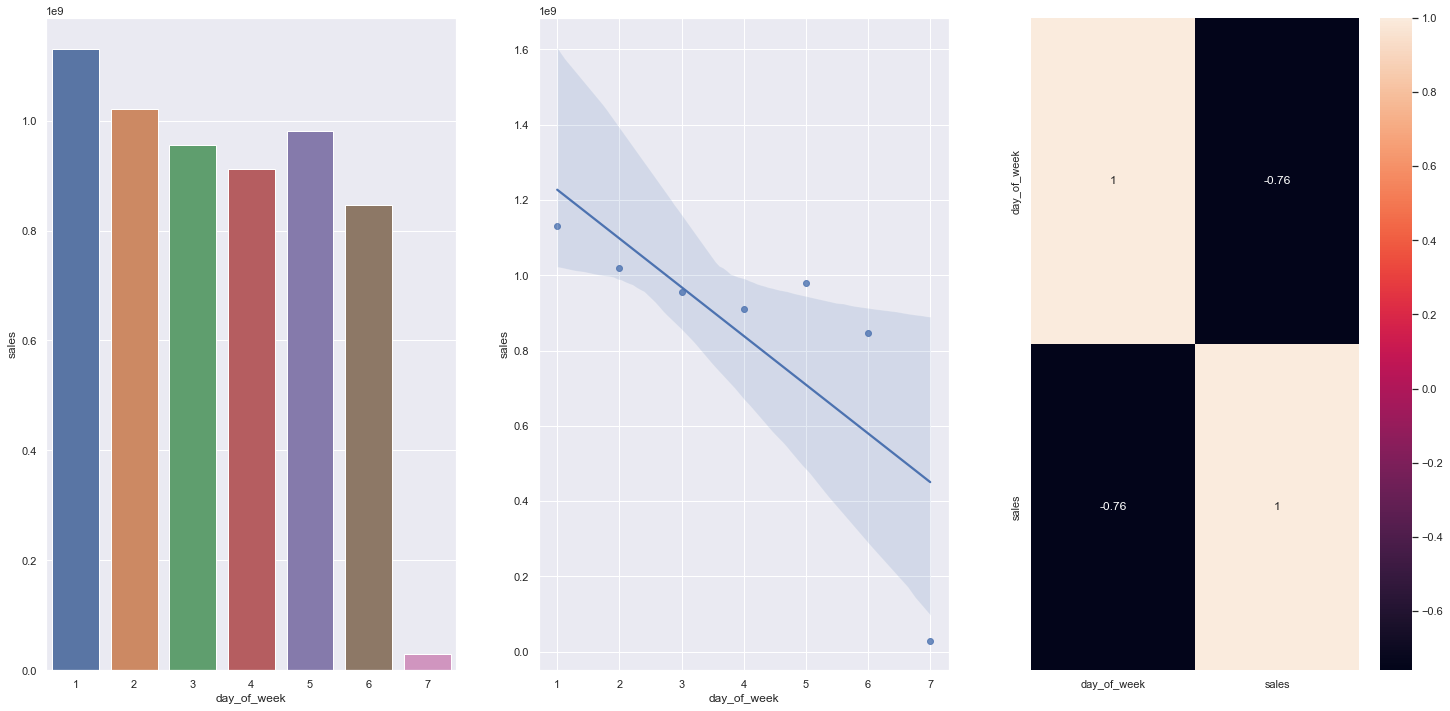

In [48]:
aux3 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux3);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux3);

plt.subplot(1,3,3)
sns.heatmap(aux3.corr(method ='pearson'), annot=True);


### 13. Lojas deveriam vender menos durante os feriados escolares.

Verdadeira - vendem menos durante as Feriados escolares, exceto Julho e Agosto

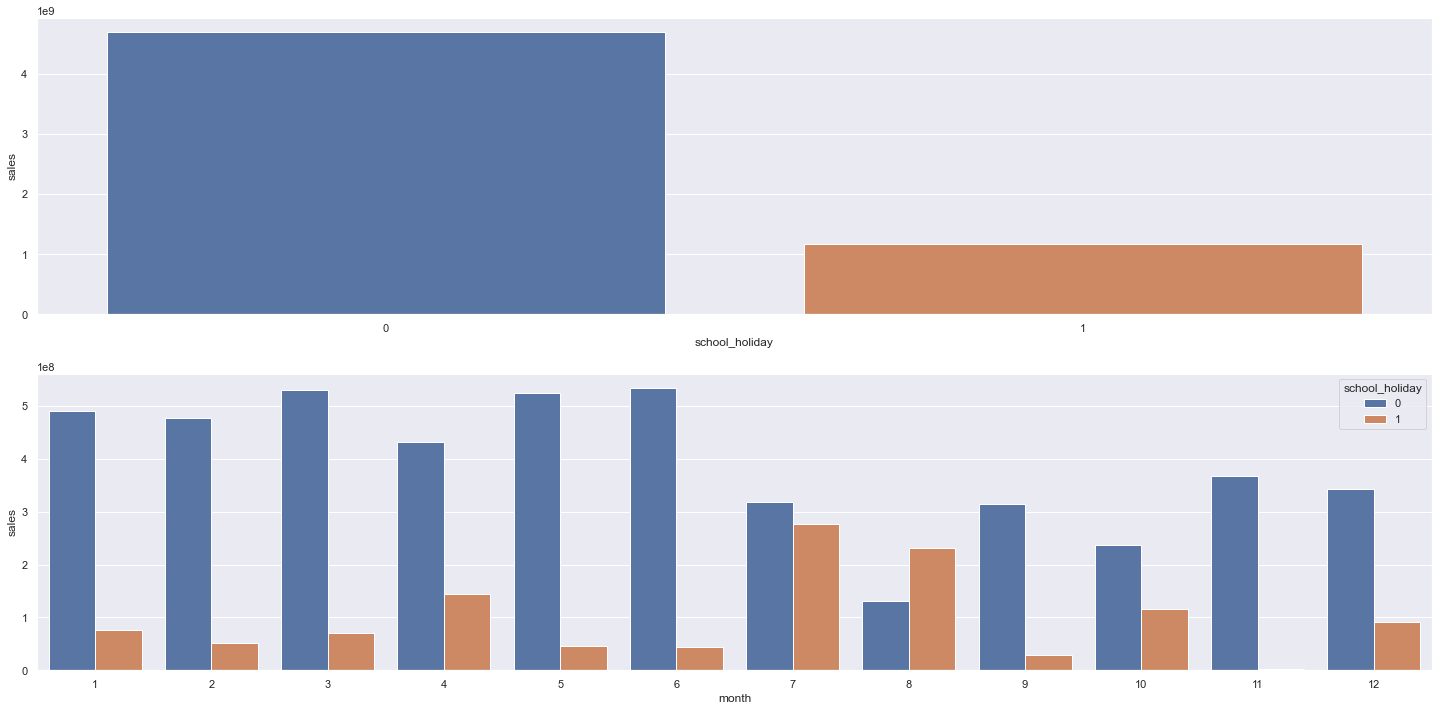

In [49]:
aux3 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux3);

aux4 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux4);


### 14. Lojas com mais Funcionarios, devem vender mais


Verdadeira - vendem menos durante as Feriados escolares, exceto Julho e Agosto

In [50]:
df4.head(10)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
5,6,5,2015-07-31,5651,1,regular_day,1,a,basic,310.0,12,2013,0,31,2015,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
6,7,5,2015-07-31,15344,1,regular_day,1,a,extended,24000.0,4,2013,0,31,2015,0,2015,7,31,31,2015-30,2013-04-01,28,2015-07-27,0
7,8,5,2015-07-31,8492,1,regular_day,1,a,basic,7520.0,10,2014,0,31,2015,0,2015,7,31,31,2015-30,2014-10-01,10,2015-07-27,0
8,9,5,2015-07-31,8565,1,regular_day,1,a,extended,2030.0,8,2000,0,31,2015,0,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0
9,10,5,2015-07-31,7185,1,regular_day,1,a,basic,3160.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


## 4.3 - Analise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot: >

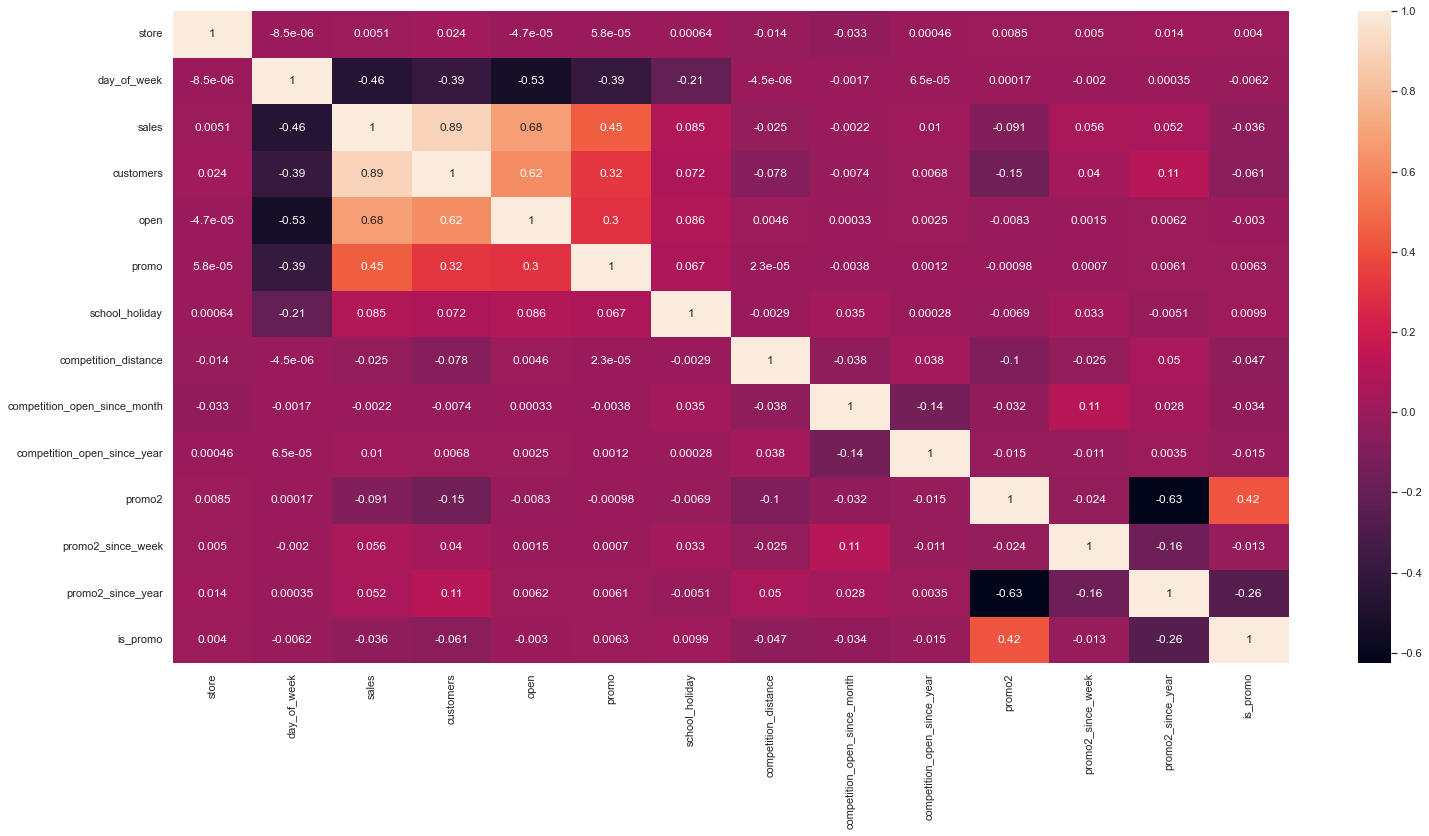

In [51]:
correlation = num_attribute.corr(method = 'pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [52]:
a.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
63559,5,4,2015-06-04,5807,1,public_holiday,0,a,basic,29910.0,4,2015,0,23,2015,0,2015,6,4,23,2015-22,2015-04-01,2,2015-06-01,0
63560,6,4,2015-06-04,5749,1,public_holiday,0,a,basic,310.0,12,2013,0,23,2015,0,2015,6,4,23,2015-22,2013-12-01,18,2015-06-01,0
63609,55,4,2015-06-04,5984,1,public_holiday,0,a,basic,720.0,11,2004,0,23,2015,0,2015,6,4,23,2015-22,2004-11-01,128,2015-06-01,0
63611,57,4,2015-06-04,9301,1,public_holiday,0,d,extended,420.0,6,2014,0,23,2015,0,2015,6,4,23,2015-22,2014-06-01,12,2015-06-01,0
63614,60,4,2015-06-04,10399,1,public_holiday,0,d,extended,5540.0,10,2009,0,23,2015,0,2015,6,4,23,2015-22,2009-10-01,69,2015-06-01,0


In [56]:
#only categorical Data
a = df4.select_dtypes(include=object)

#calculate cramer_v
a1= (cramer_v(a['state_holiday'], a['state_holiday']))
a2= (cramer_v(a['state_holiday'], a['store_type']))
a3= (cramer_v(a['state_holiday'], a['assortment']))

a4= (cramer_v(a['store_type'], a['state_holiday']))
a5= (cramer_v(a['store_type'], a['store_type']))
a6= (cramer_v(a['store_type'], a['assortment']))

a7= (cramer_v(a['assortment'], a['state_holiday']))
a8= (cramer_v(a['assortment'], a['store_type']))
a9= (cramer_v(a['assortment'], a['assortment']))

#final Dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9]})

d = d.set_index (d.columns)
#HeatMap
sns.heatmap (d, annot=True)

NameError: name 'ss' is not defined

# 5.0  Data Preparation


In [119]:
df5 = df4.copy()

In [120]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 Normalization

Nao foi feito nenhuma Normalization.

## 5.2 Rescaling


In [121]:
a = df5.select_dtypes(include =['int64', 'float'])
a.dtypes

store                             int64
day_of_week                       int64
sales                             int64
promo                             int64
school_holiday                    int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
is_promo                          int64
year                              int64
month                             int64
day                               int64
competition_time_month            int64
promo_time_week                   int64
dtype: object

<AxesSubplot: >

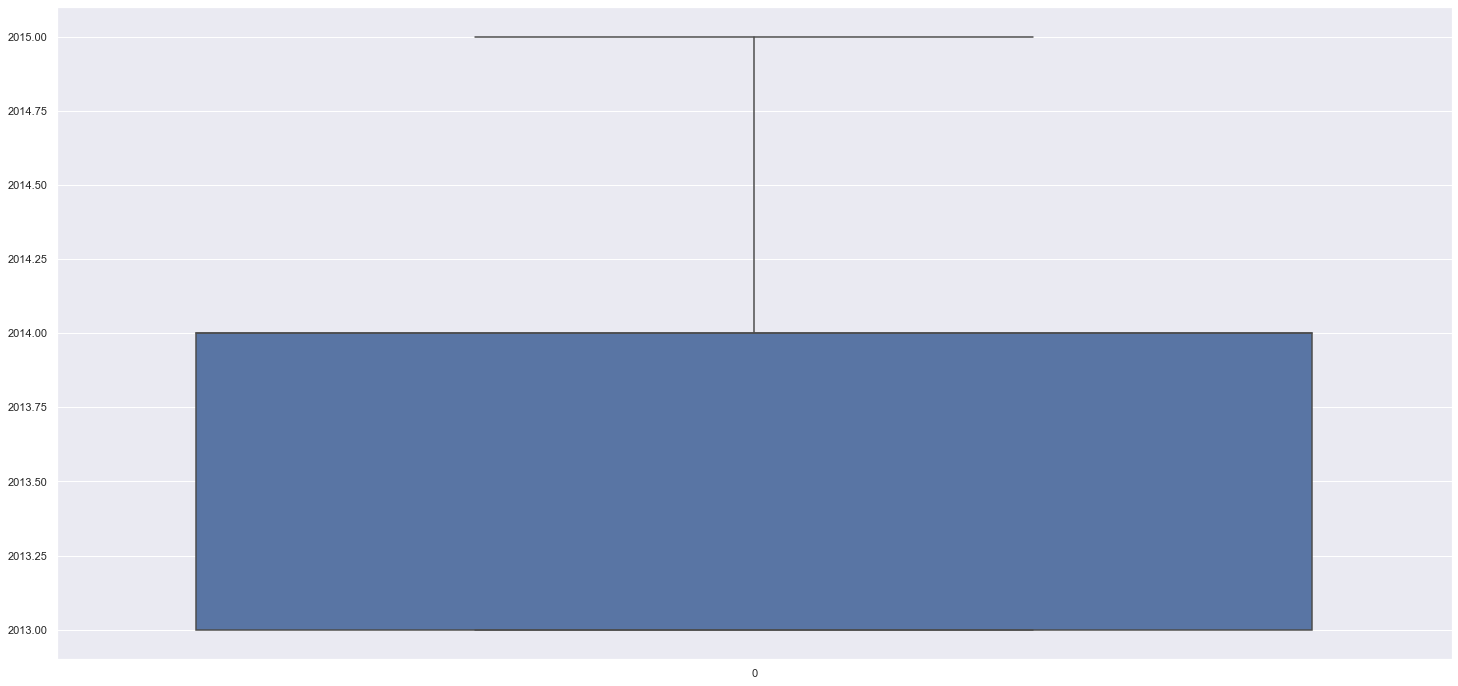

In [122]:
sns.boxplot( df5['year'])

In [123]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

pickle.dump(rs, open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/Webapp/parameter/competition_distance_scaler.pkl', 'wb') ) 


#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/Webapp/parameter/competition_time_month_scaler.pkl', 'wb') ) 


#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/Webapp/parameter/promo_time_week_scaler.pkl', 'wb') ) 

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(rs, open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/Webapp/parameter/year_scaler.pkl', 'wb') ) 



/var/folders/55/kp2841xx6lgfq642dzt475640000gn/T/ipykernel_10009/2494862100.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['competition_distance'] );


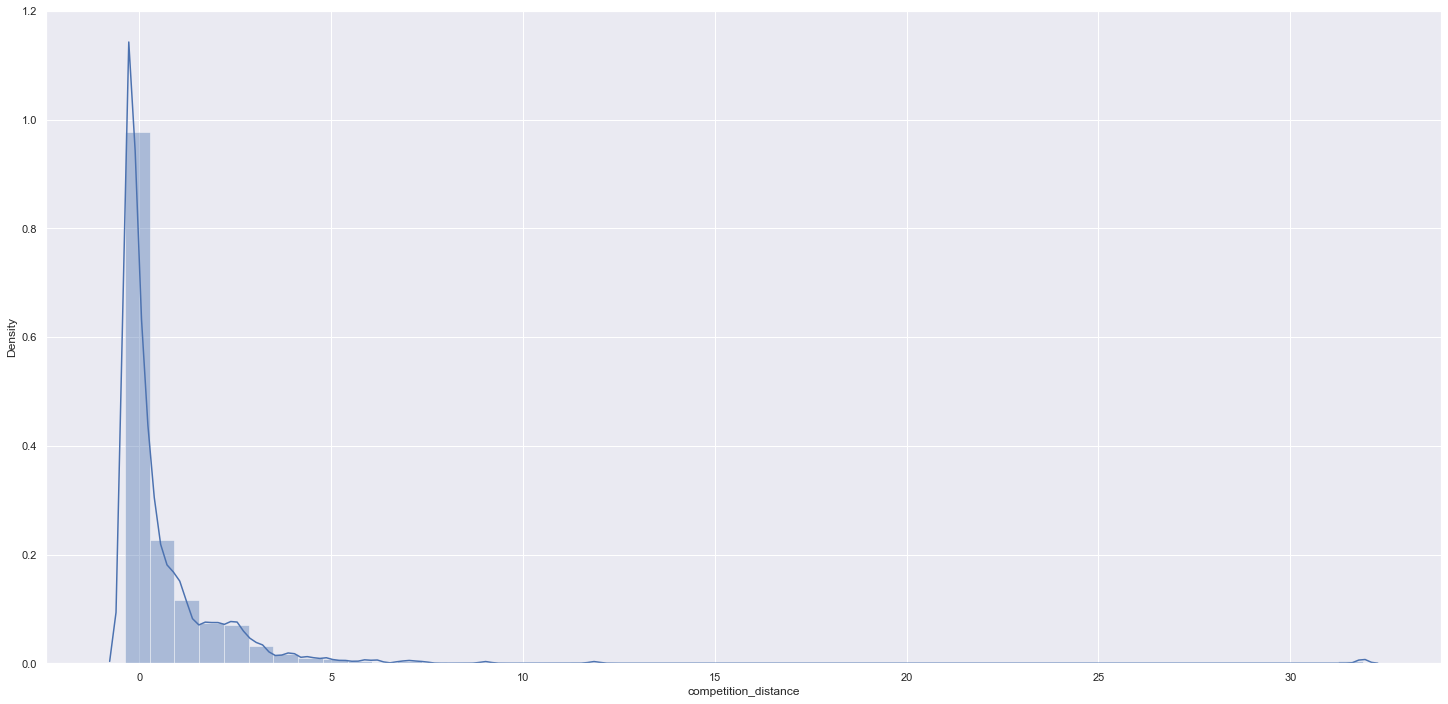

In [124]:
sns.distplot(df5['competition_distance'] );

## 5.3 Transformation

### 5.3.1 Encoding

In [125]:
#state_holiday - One Hot Enconding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns=['state_holiday'])

In [126]:
#store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/Webapp/parameter/store_type_scaler.pkl', 'wb') ) 

#assortment
assortment_dict= {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [127]:
df5.sample(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
760151,507,1,2013-08-19,6750,0,1,0,3,1.087097,4,2011,1,37,2009,0,0.0,8,19,34,2013-33,2011-04-01,0.175676,2009-09-07,0.756264,0,0,0,1
497877,258,5,2014-04-11,4871,0,0,0,1,4.009677,7,2010,1,37,2009,1,0.5,4,11,15,2014-14,2010-07-01,0.405405,2009-09-07,0.831435,0,0,0,1
110471,87,4,2015-04-23,5486,0,0,0,1,-0.285484,12,2010,0,17,2015,0,1.0,4,23,17,2015-16,2010-12-01,0.500000,2015-04-20,0.287016,0,0,0,1
1012769,20,5,2013-01-04,5599,0,1,3,1,0.001613,5,2009,1,40,2014,1,0.0,1,4,1,2013-00,2009-05-01,0.378378,2014-09-29,0.079727,0,0,0,1
970129,865,2,2013-02-12,5737,0,0,3,3,0.050000,2,2013,0,7,2013,0,0.0,2,12,7,2013-06,2013-02-01,-0.216216,2013-02-11,0.287016,0,0,0,1
422388,589,3,2014-06-18,6749,1,0,0,3,-0.317742,6,2014,1,18,2013,0,0.5,6,18,25,2014-24,2014-06-01,-0.216216,2013-04-29,0.421412,0,0,0,1
816731,222,6,2013-06-29,3286,0,0,0,1,-0.025806,11,2008,0,26,2013,0,0.0,6,29,26,2013-25,2008-11-01,0.540541,2013-06-24,0.287016,0,0,0,1
227179,835,5,2015-01-09,5895,1,0,0,1,0.090323,12,2007,1,10,2014,0,1.0,1,9,2,2015-01,2007-12-01,0.945946,2014-03-03,0.387244,0,0,0,1
615425,731,5,2013-12-27,10698,0,1,0,1,2.087097,12,2013,1,10,2014,0,0.0,12,27,52,2013-51,2013-12-01,-0.216216,2014-03-03,0.264237,0,0,0,1
905368,774,4,2013-04-11,5479,1,0,0,3,-0.272581,9,2013,0,15,2013,0,0.0,4,11,15,2013-14,2013-09-01,-0.283784,2013-04-08,0.287016,0,0,0,1


###  5.3.2 Response Variable Transformation

In [128]:
df5['sales'] = np.log1p(df5['sales'])

/var/folders/55/kp2841xx6lgfq642dzt475640000gn/T/ipykernel_10009/4056287585.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['sales'])


<AxesSubplot: xlabel='sales', ylabel='Density'>

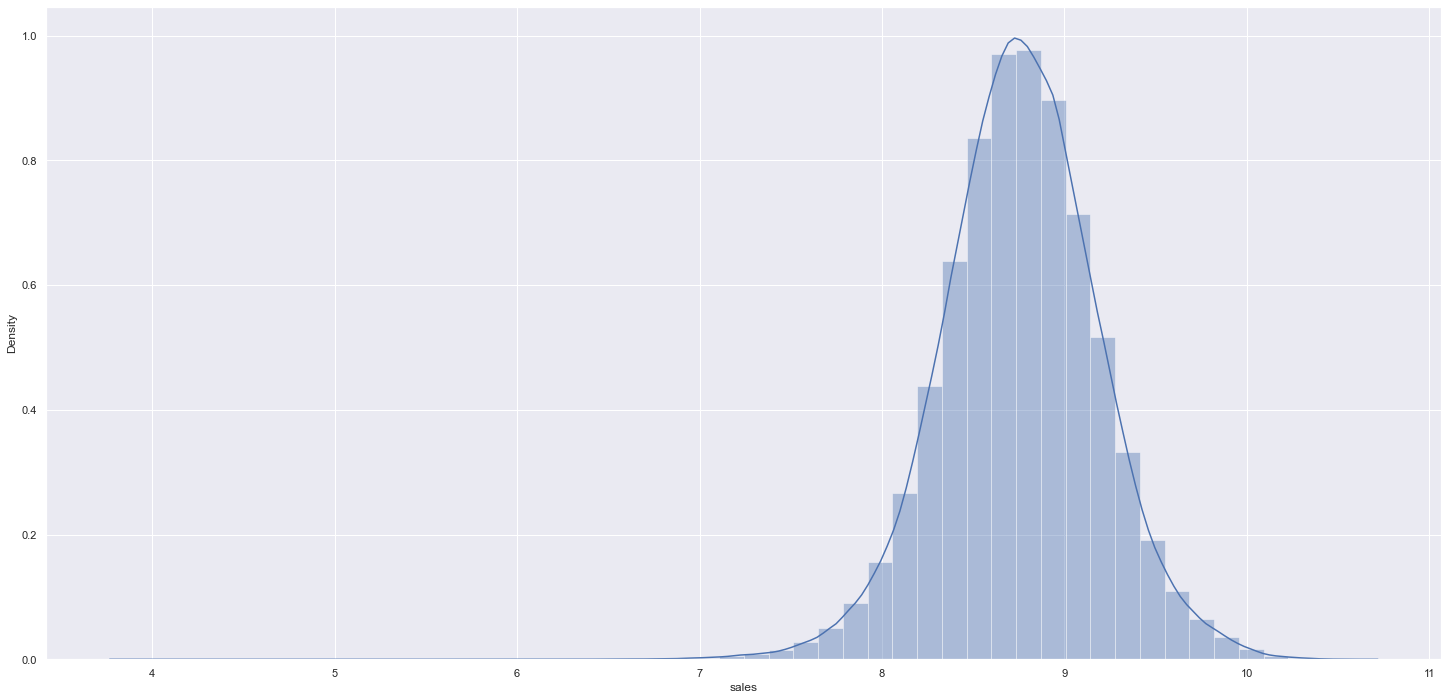

In [129]:
sns.distplot(df5['sales'])

### 5.3.3. Natural Transformation

In [130]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))

In [131]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0  Feature Selection

In [132]:
df6 = df5.copy()

In [133]:
df6.dtypes 

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_since               datetime64[ns]
competition_t

In [134]:
#drop columnns duplicated/Derivated
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']

df6 =df6.drop(cols_drop, axis=1)

## 6.1 Slipt DataFrame into Training and Test Dataset

In [135]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [136]:
#Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Trainning Min Date {}'.format(X_train['date'].min()))
print('Trainning Max Date {}'.format(X_train['date'].max()))

print('\nTest Min Date {}'.format(X_test['date'].min()))
print('Test Max Date {}'.format(X_test['date'].max()))



Trainning Min Date 2013-01-01 00:00:00
Trainning Max Date 2015-06-18 00:00:00

Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2 Boruta as Feacture Selector

In [137]:
##Trainning and DataSet for Boruta
#X_train_n = X_train.drop(['date','sales'],axis =1 ).values
#Y_train_n = Y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#Define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit (X_train_n, Y_train_n)

In [138]:
#cols_selected = boruta.support_.tolist()


## Best Dataset Feature Selected
#X_train_fs = X_train.drop(['date','sales'],axis =1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()


#Not Select Boruta
#cols_not_selected_boruta= list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [139]:
#cols_selected_boruta

In [140]:
#cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [141]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos','month_sin', 'day_sin', 'day_cos','week_of_year_cos','week_of_year_sin']

In [142]:
#columns to Add
feat_to_add = ['date','sales']

#Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [143]:
df7 = df6.copy()

In [145]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time-Series Prepararion
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [146]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performace
baseline_result = m1_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RSME
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [148]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performace
lr_result = m1_error('Liner Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RSME
0,Liner Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [149]:
#promo_time_week
pickle.dump(rs, open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/Webapp/parameter/promo_time_week_scaler.pkl', 'wb') ) 

In [150]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr , verbose= True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


In [113]:
#Salvando o modelo RS_Result
import pickle
pickle.dump(lr_result_cv, open('/Users/jefersonlima/Desktop/Models/lr_result_cv.pkl','wb'))

NameError: name 'lr_result_cv' is not defined

## 7.3 Linear Regression Regularized Model - Lasso

In [151]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performace
lrr_result = m1_error('Liner Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RSME
0,Liner Regression - Lasso,1891.704881,0.289106,2744.451737


In [116]:
#Salvando o modelo RS_Result
import pickle
pickle.dump(lrr_result, open('/Users/jefersonlima/Desktop/Models/lrr_result.pkl','wb'))

### 7.3.1 Linear Regression Regularized Lasso  - Cross Validation

In [152]:
import pickle
lrr_result = open('/Users/jefersonlima/Desktop/Models/lrr_result.pkl','rb')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jefersonlima/Desktop/Models/lrr_result.pkl'

In [153]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr , verbose= True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RSME CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


In [119]:
#Salvando o modelo RS_Result
import pickle
pickle.dump(lrr_result_cv, open('/Users/jefersonlima/Desktop/Models/lrr_result_cv.pkl','wb'))

## 7.4 Random Forest Regressor

In [120]:
#importando Modelo pronto
import pickle
rf_result = pickle.load( open('/Users/jefersonlima/Desktop/Models/rf_result.pkl','rb') )
rf_result

,Model Name,MAE,MAPE,RSME
0,Random Forest Regressor,678.318902,0.099751,1009.085744


In [121]:
#model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
#yhat_rf = rf.predict(x_test)

#performace
#rf_result = m1_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

In [122]:
#Salvando o modelo RS_Result
#import pickle
#pickle.dump(rf_result, open('/Users/jefersonlima/Desktop/Models/rf_result.pkl','wb'))

### 7.4.1 Random Forest Regressor  - Cross Validation

In [123]:
#importando Modelo pronto
rs_resul_cv = pickle.load( open('/Users/jefersonlima/Desktop/Models/rs_resul_cv.pkl','rb') )
rs_resul_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,838.09 +/- 218.05,0.12 +/- 0.02,1256.86 +/- 318.17


In [124]:
#model test
#rs_resul_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf , verbose= True)
#rs_resul_cv

In [125]:
#Save o modelo RS_Result
#import pickle
#pickle.dump(rs_resul_cv, open('/Users/jefersonlima/Desktop/Models/rs_resul_cv.pkl','wb'))

## 7.5 XGBoost Regressor

In [140]:
#importando Modelo pronto
xgb_result = pickle.load( open('/Users/jefersonlima/Desktop/Models/xgb_result.pkl','rb') )
xgb_result

,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,683.818768,0.099075,988.59821


In [124]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=3500, #padrao #100
                             eta=0.3,         #padrao #0.01
                             max_depht=5,     #padrao #10
                             subsample=0.5,     #padrao #0.7
                             colsample_bytee=0.9,  #padrao #0.9
                            min_child_weight=3 ).fit(x_train, y_train)    

#prediction
yhat_xgb = model_xgb.predict( x_test)

#performace
xgb_result = m1_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[12:26:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bytee", "max_depht" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,683.818768,0.099075,988.59821


In [126]:
#Salvando o modelo xgb_result
pickle.dump(xgb_result, open('/Users/jefersonlima/Desktop/Models/xgb_result.pkl','wb'))

### 7.5.1 XGBoost Regressor  - Cross Validation

In [127]:
#Delay of 31 hours
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb , verbose= False)
#xgb_result_cv

## 7.6 Compare Model's Performance 

### 7.6.1 Single Performace

In [143]:
modelling_result = pd.concat([baseline_result,lrr_result,lr_result,rf_result,xgb_result])
modelling_result.sort_values('RSME')

,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,683.818768,0.099075,988.598210
0,Random Forest Regressor,678.318902,0.099751,1009.085744
0,Average Model,1354.800353,0.206400,1835.135542
0,Liner Regression,1867.089774,0.292694,2671.049215
0,Liner Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [130]:
#modelling_result_cv= pd.concat([lr_result_cv,lrr_result_cv,rs_resul_cv,xgb_result_cv])
#modelling_result_cv.sort_values('RSME')

modelling_result_cv= pd.concat([lr_result_cv,lrr_result_cv,rs_resul_cv])
modelling_result_cv.sort_values('RSME CV')

,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,838.09 +/- 218.05,0.12 +/- 0.02,1256.86 +/- 318.17
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


In [130]:
#modelling_result_cv= pd.concat([lr_result_cv,lrr_result_cv,rs_resul_cv,xgb_result_cv])
#modelling_result_cv.sort_values('RSME')

modelling_result_cv= pd.concat([lr_result_cv,lrr_result_cv,rs_resul_cv])
modelling_result_cv.sort_values('RSME CV')

,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,838.09 +/- 218.05,0.12 +/- 0.02,1256.86 +/- 318.17
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0 Hyperameter Fine Tuning

In [84]:
df8 = df7.copy()

## 8.1 Random Search

In [93]:
param = {'n_estimators': [1500,1700,300,200], #3500
        'eta': [0.1, 0.03], #0.3
        'max_depht': [3, 5,9], #5
        'subsample': [0.1,0.5,0.7], #0.5
        'colsample_bytee':[0.3,0.5,0.9], #0.9
        'min_child_weight': [3,8,10,11]  #3}

max_eval = 2

SyntaxError: invalid syntax (3568193131.py, line 8)

In [94]:
#xgb_result = pd.DataFrame()

#for i in range (max_eval):
    #Choose Values for parameters randoly
#    hp = { k: random.sample (v, 1) [0] for k, v in param.items()}
#    print(hp)
#    
#    #model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depht=hp['max_depht'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytee=hp['colsample_bytee'],
#                                 min_child_weight=hp['min_child_weight'])
#
#
#   #performace
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb , verbose= True)
#    xgb_result = pd.concat([xgb_result,result])
#                                              
#                                              
#xgb_result

## 8.2 Final Model

In [97]:
yhat_xgb_tuned = yhat_xgb

NameError: name 'yhat_xgb' is not defined

In [138]:
param_tuned = {'n_estimators': 3000,
        'eta':0.03,
        'max_depht':5 ,
        'subsample':0.7 ,
        'colsample_bytee': 0.7,
        'min_child_weight': 3 }


In [139]:
##model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depht=param_tuned['max_depht'],
                             subsample=param_tuned['subsample'],
                             colsample_bytee=param_tuned['colsample_bytee'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test)

#performace
xgb_result_tuned = m1_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

[20:49:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bytee", "max_depht" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,693.763849,0.102824,1000.830591


In [142]:
#Salvando o modelo
import pickle
pickle.dump(model_xgb_tuned, open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/model_rossmann.pkl','wb'))

# 9.0 Traducao e Interpretacao e Erro

In [142]:
df9 = X_test[cols_selected_boruta_full]

In [146]:
#rescale 
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb)

/Users/jefersonlima/.pyenv/versions/3.8.3/envs/rossmannstoreprediction/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/3p/c24f64gs2w72lsnd2h_ykph80000gn/T/ipykernel_3831/1976444143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])


TypeError: loop of ufunc does not support argument 0 of type str which has no callable expm1 method

## 9.1 Business Performance

In [172]:
#Sum of Predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

#Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [175]:
df92.sort_values( 'MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106483.000000,103151.519930,109814.480070,3331.480070,0.546020
908,909,247026.000000,239257.401303,254794.598697,7768.598697,0.536806
182,183,213883.578125,211984.226255,215782.929995,1899.351870,0.320621
875,876,193177.140625,189142.859768,197211.421482,4034.280857,0.302292
99,100,379407.968750,377317.887616,381498.049884,2090.081134,0.271335


<AxesSubplot: xlabel='store', ylabel='MAPE'>

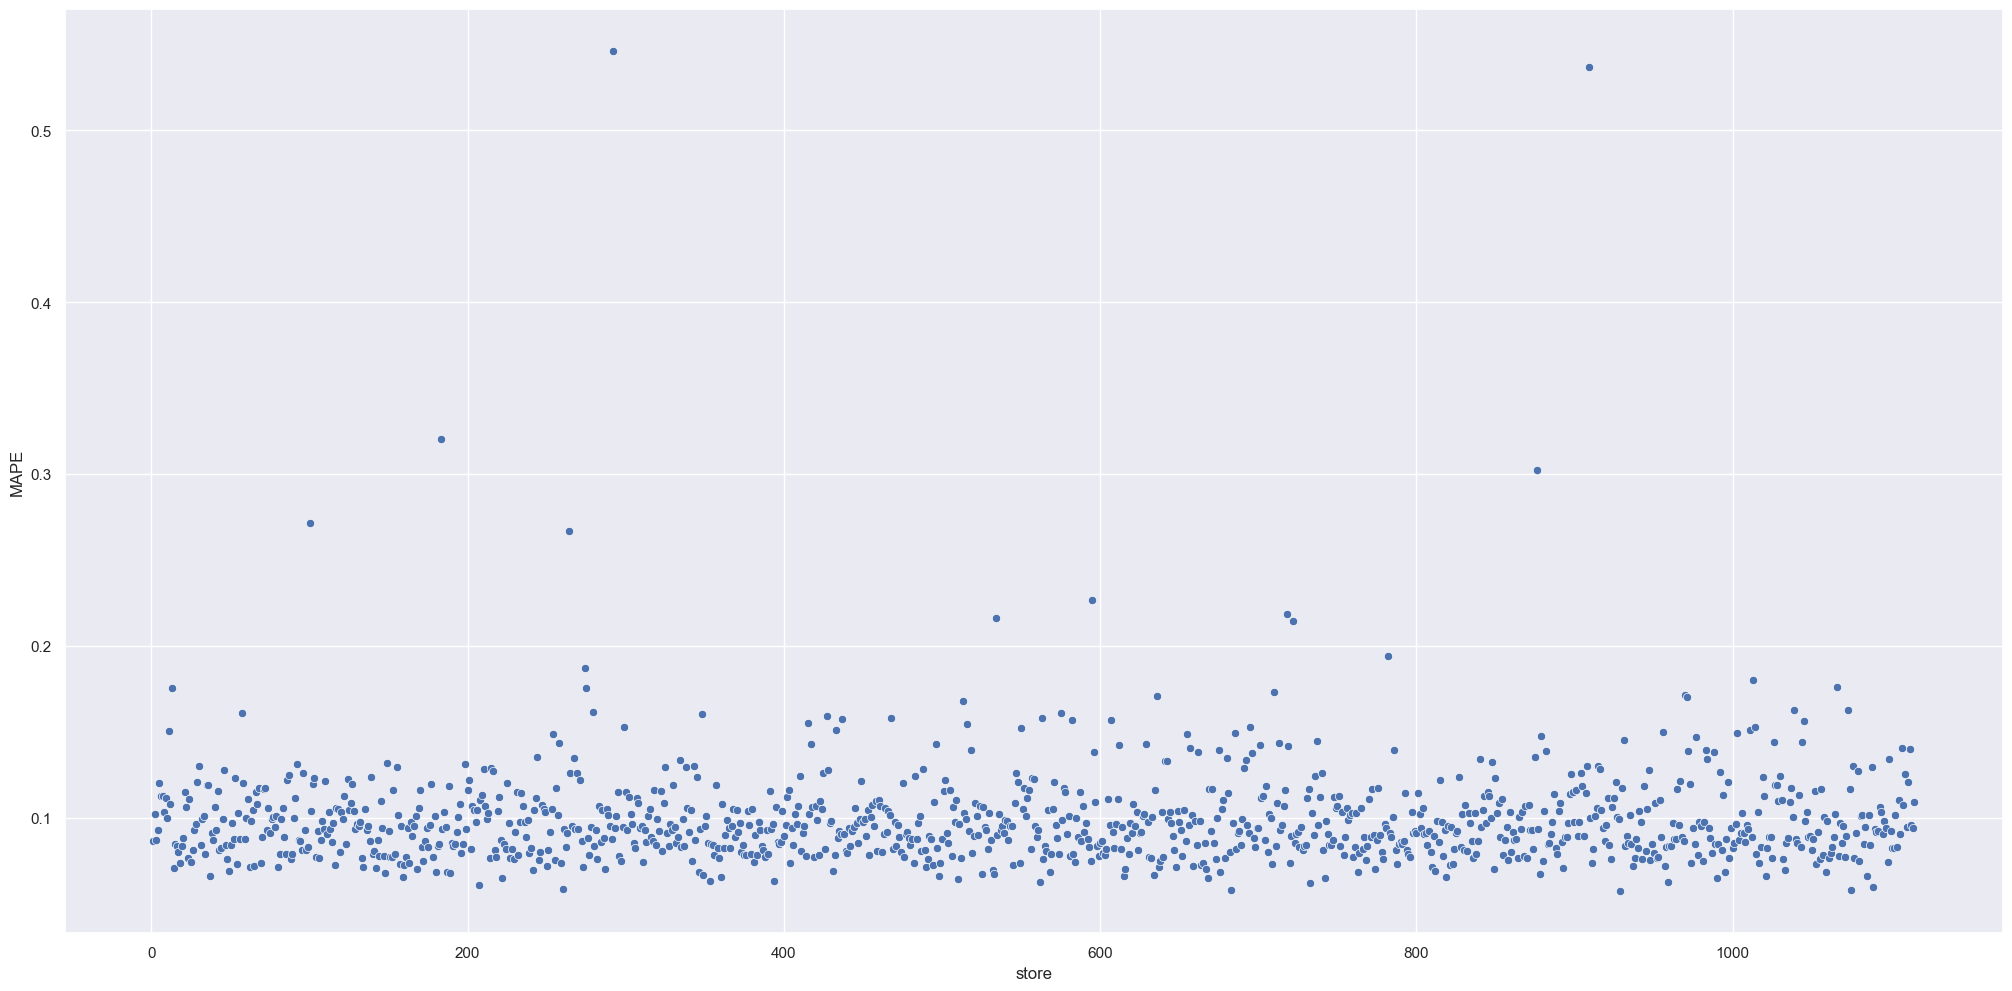

In [176]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [186]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply( lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$283,636,032.00"
1,worst_scenario,"R$282,869,307.99"
2,best_scenario,"R$284,402,759.88"


## 9.3 Machine Learning Performance

In [188]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/var/folders/3p/c24f64gs2w72lsnd2h_ykph80000gn/T/ipykernel_2688/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/var/folders/3p/c24f64gs2w72lsnd2h_ykph80000gn/T/ipykernel_2688/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


In [195]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_sin,day_cos,week_of_year_cos,week_of_year_sin,date,sales,predictions,error,error_rate
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,5263.0,5856.571289,-593.571289,1.112782
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,6064.0,5487.146484,576.853516,0.904872
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,8314.0,9014.166992,-700.166992,1.084215
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,13995.0,13409.365234,585.634766,0.958154
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,4822.0,7898.698242,-3076.698242,1.638054


/var/folders/3p/c24f64gs2w72lsnd2h_ykph80000gn/T/ipykernel_2688/2364429716.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df9['error'])
/var/folders/3p/c24f64gs2w72lsnd2h_ykph80000gn/T/ipykernel_2688/2364429716.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot( data=df9, x='predictions', y='error',  palette="deep")


<AxesSubplot: xlabel='predictions', ylabel='error'>

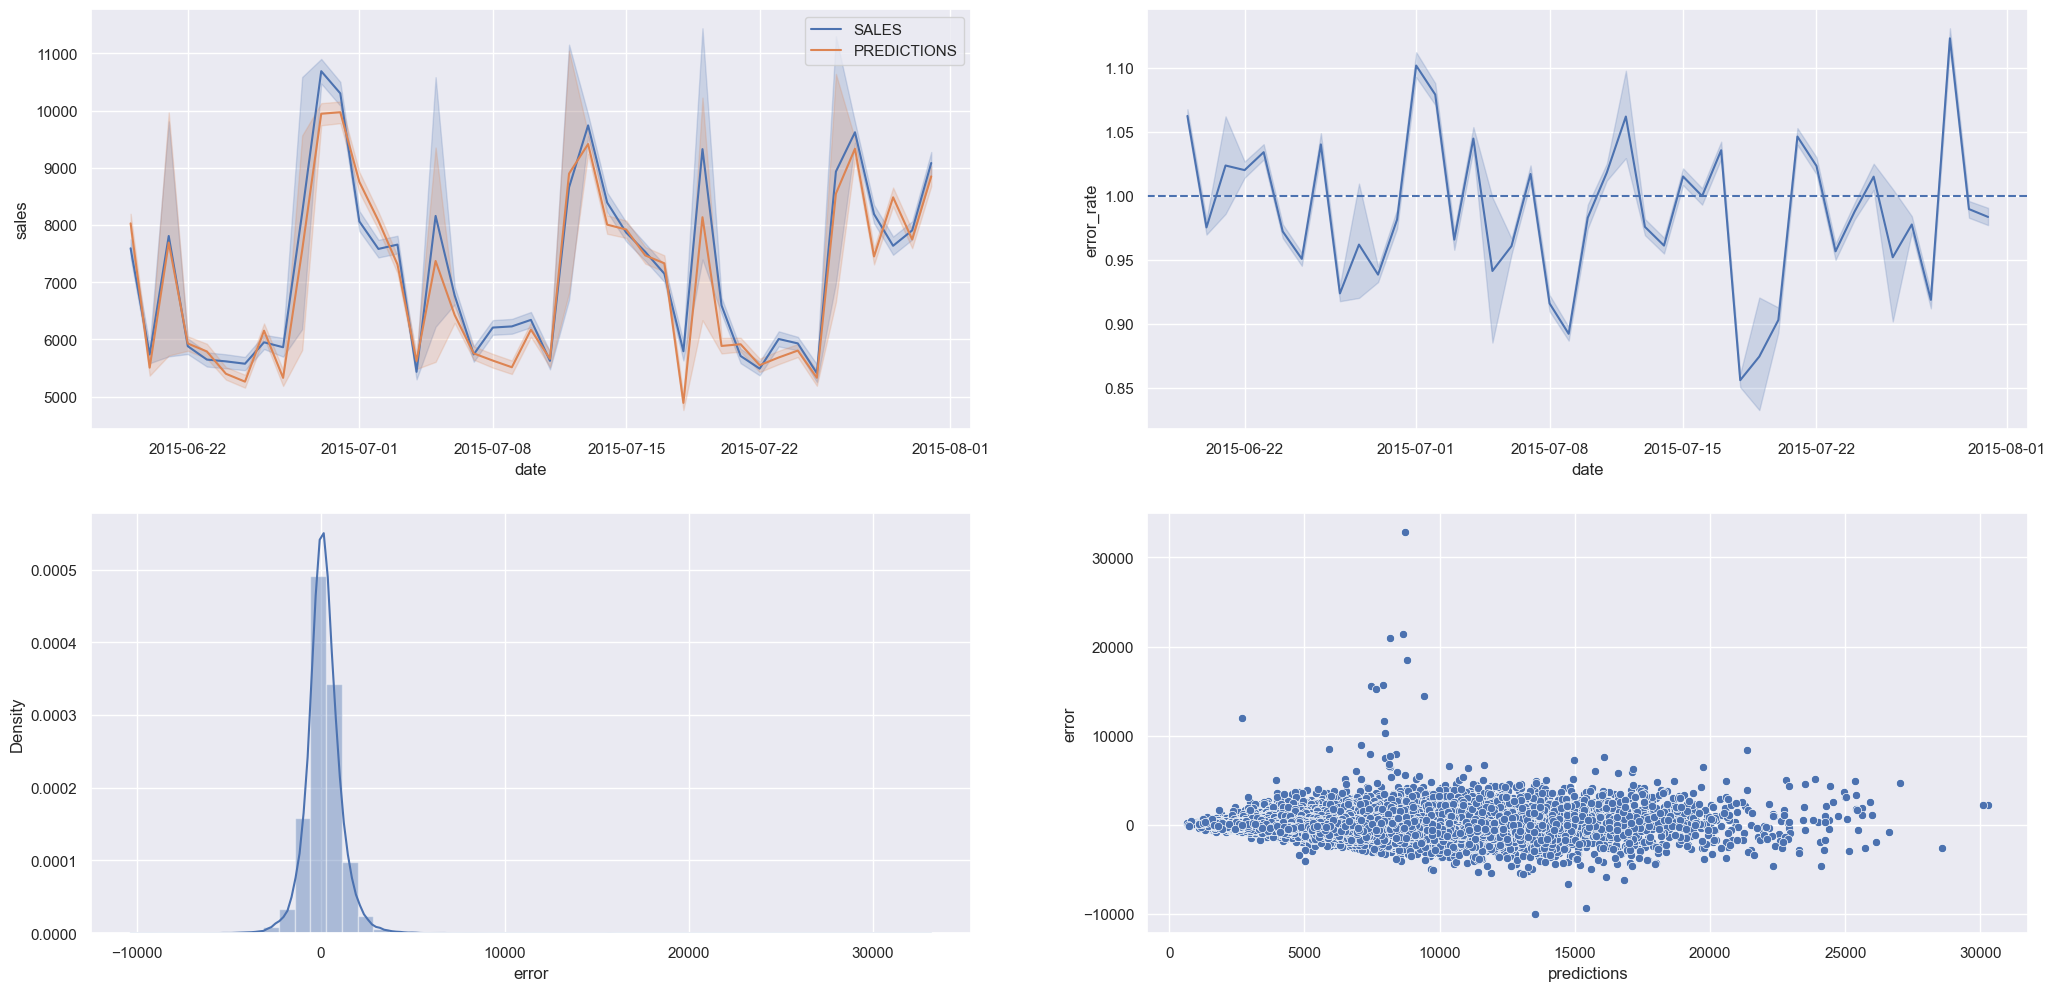

In [198]:
plt.subplot( 2, 2, 1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'])

plt.subplot( 2, 2, 4)
sns.scatterplot( data=df9, x='predictions', y='error',  palette="deep")



# 10.0 Deploy Model to Production

## 10.1 Class Rossmann

In [261]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class rossmann (object ): 
    def __init__(self):
        state = 1
        self.competition_distance_scaler = pickle.load(open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/parameter/competition_distance_scaler.pkl', 'rb') ) 
        self.competition_time_month_scaler = pickle.load(open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/parameter/competition_time_month_scaler.pkl', 'rb') ) 
        self.promo_time_week_scaler = pickle.load(open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/parameter/promo_time_week_scaler.pkl', 'rb') ) 
        self.year_scaler = pickle.load(open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/parameter/year_scaler.pkl', 'rb') ) 
        self.store_type_scaler = pickle.load(open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/parameter/store_type_scaler.pkl', 'rb') ) 
        self.year_scaler = pickle.load(open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/parameter/year_scaler.pkl', 'rb') ) 


        
    def data_cleaning(self,df1):

        ## 1.1. Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                    'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list(map(snakecase, cols_old))

        #Rename
        df1.columns = cols_new

        ## 1.3. Data Type
        #mudando DateTime
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.4. Check NA
        ## 1.5. Fill out NA

        df1['competition_distance'].max()


        #competition_distance    
        df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year   
        df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week 
        df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year  
        df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval 
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        ## 1.6 Change Dtypes

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        
        return df1



    def feature_engineering(self,df2):


        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], 
                                                                          month=x['competition_open_since_month'],day=1 ), axis=1 )

        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' 
                                                          else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. Filtragem de Variaveis

        ## 3.1. Filtragem das Linhas

        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2

    def data_preparation(self,df5):

        ## 5.1 Normalization

        ## 5.2 Rescaling

        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)


        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3 Transformation

        ### 5.3.1 Encoding


        #state_holiday - One Hot Enconding
        df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns=['state_holiday'])


        #store_type
        le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment
        assortment_dict= {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Natural Transformation
        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 
                                'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 
                                'month_cos','month_sin', 'day_sin', 'day_cos','week_of_year_cos','week_of_year_sin']
        
        return df5[cols_selected]

    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records',date_format='iso')

## 10.2 API Handler

In [262]:
import pickle
import os
import pandas as pd
from rossmann.Rossmann import Rossmann
from flask import Flask, request, Response 

#loading Model
model = pickle.load(open('/Users/jefersonlima/GitHub/Rossmann-Store-Prediction/Webapp/model/model_rossmann.pkl', 'rb') )


#Inicialize API
app = Flask (__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json: #there is data
        if isinstance (test_json, dict): #Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: #Multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys() )

        
        #instance
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        #data preparation
        df3 = pipeline.data_preparation(df2)

        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
        
        
    else:
        return response ('{}', status=200, mimetype='application/json')

if __name == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [231]:
import pickle
import os
import pandas as pd
from flask import Flask, request, Response 

In [232]:
import requests

In [233]:
#loading test
df10 = pd.read_csv ('../rossmann-store-sales/test.csv', low_memory=False)

In [234]:
#merge test dataset + store
df_test = pd.merge(df10,df_store_raw,how ='left', on='Store')

In [235]:
#Store with more sell: 562, 1114, 262 -- Worst Sell 969 764 622

#choose Store for Predictions
df_test = df_test[df_test['Store'].isin(np.arange(1116))]
#df_test= df_test[df_test['Store'].isin([22])]
#df_test = df_test[df_test['Store'].isin(a)]


#remove closed days
df_test = df_test[df_test['Open']!= 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)



In [236]:
#convert DataFrame to Json

data = json.dumps(df_test.to_dict(orient='records'))

In [237]:
#API Call

#url local
#url='http://0.0.0.0:5000/rossmann/predict' #url-local

url='https://rossmannsalesapi.herokuapp.com/rossmann/predict'#WebApp 
header={'Content-Type': 'application/json'}
data= data

r = requests.post(url,data=data,headers=header)
print('Status Code {}'.format( r.status_code))

Status Code 200


In [238]:
d1 = pd.DataFrame (r.json(), columns=r.json()[0].keys())

In [249]:
d2 = d1 [['store','prediction']].groupby('store').sum().reset_index()

for i in range( len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks' .format(d2.loc[i, 'store'],
                                                                     d2.loc[i, 'prediction']))

Store Number 1 will sell R$190,218.88 in the next 6 weeks
Store Number 3 will sell R$270,138.60 in the next 6 weeks
Store Number 7 will sell R$265,424.39 in the next 6 weeks
Store Number 8 will sell R$237,519.79 in the next 6 weeks
Store Number 9 will sell R$250,389.89 in the next 6 weeks
Store Number 10 will sell R$200,365.60 in the next 6 weeks
Store Number 11 will sell R$315,063.73 in the next 6 weeks
Store Number 12 will sell R$266,134.13 in the next 6 weeks
Store Number 13 will sell R$199,505.66 in the next 6 weeks
Store Number 14 will sell R$196,491.13 in the next 6 weeks
Store Number 15 will sell R$271,875.44 in the next 6 weeks
Store Number 16 will sell R$286,916.33 in the next 6 weeks
Store Number 19 will sell R$260,510.64 in the next 6 weeks
Store Number 20 will sell R$271,037.10 in the next 6 weeks
Store Number 21 will sell R$208,864.24 in the next 6 weeks
Store Number 22 will sell R$193,261.97 in the next 6 weeks
Store Number 23 will sell R$211,656.66 in the next 6 weeks
St

In [256]:
d2.sort_values(by='prediction', inplace=True, ascending=False, ignore_index=False )
d2


,store,prediction
0,1114,743426.899414
1,562,637141.033203
2,335,554819.732422
3,262,554371.267578
4,449,533224.938477
5,842,510691.527344
6,822,506485.649414
7,756,497658.060547
8,383,479288.762207
9,733,470375.176758


In [92]:
d2.to_csv('all.csv')

In [ ]:
credenciais.py

credentials = {
   
   'NOME_USUARIO': 'teste@gmail.com',
   'SENHA': 'SenhaSecreta',
   'API_KEY': 'minha_api_key12345' 
}

In [ ]:
from credentials import credentials

# constants
cred = credentials()
TOKEN = cred.TOKEN
